# **Deep Learning Assignment** 
## Question 2
***
> Submitted by: &emsp;**Aw Chong Kiang (22034803)** <br>
Date: &emsp;&emsp;&emsp;&emsp;&ensp;**4 Jul 2022**

## Objective: Build a Convolutional Neural Network model, using Transfer Learning to classify Pokemon

<img src="data/pokemon.jpg" width="500" height="500">


## Import Libraries

In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import imagehash
import math
import splitfolders
from distutils.dir_util import copy_tree
from statistics import mean
from PIL import Image
from time import time

%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import confusion_matrix
from keras import models
from keras import layers
from keras import regularizers
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize


## Function Definition

In [57]:
def show_image(maindir: str, subdir: str, filename: str):
    """Display image and image size given main directory, sub-folder and filename"""
    
    image_path = os.sep.join([maindir, subdir, filename])
    image = mpimg.imread(image_path)
    plt.axis('off')
    plt.imshow(image)
    
    

def cal_rowcol(num_plots: int, ncol: int = 5) -> (int, int):
    """Calculate optimal rows and columns given number of graphs to be plotted"""
    
    # Force max number of columns to ncol
    if num_plots < 0:
        row, col = 0, 0
    elif num_plots <= ncol:
        row, col = 1, num_plots
    else:
        row, col = int(math.ceil(num_plots/ncol)), ncol
    
    return row, col



def image_dict(maindir: str ) -> (int, dict):
    """Generate list of files in all sub-folders of main directory"""
    
    total = 0
    img_dict = {}
        
    for subdir in os.listdir(maindir):
        filepath = os.sep.join([maindir, subdir])
        filelist = [name for name in os.listdir(filepath) if '.' in name]
        img_dict[subdir] = filelist
        print("No. of images in '{}' sub-folder under '{}' folder : {}".format(subdir, maindir, len(filelist)))
        
        # Increment number of files per sub-folder
        total += len(filelist)
    
    print("\nTotal no. of images in '{}' folder : {}".format(maindir, total))
    
    return total, img_dict



def remove_image(maindir: str, datadict: dict) -> (int, dict):
    """Remove images found in main directory including its sub-directories"""
    
    for subdir in datadict.keys():
        for filename in datadict[subdir]:
            filepath = os.sep.join([maindir, subdir, filename])
                
            # Check if file exists before removing
            if os.path.exists(filepath):
                os.remove(filepath)
    
    total, img_dict = image_dict(maindir)
    
    return total, img_dict



def convert_image(src: str, dst: str) -> str:
    """Convert image file type based on destination file path"""
    
    format_to_mode = {'jpg': 'RGB', 'jpeg': 'RGB', 'png': 'RGBA'}
    req_format = dst.split('.')[1]
    
    if req_format not in format_to_mode.keys():
        print("Invalid file format to be converted!")
    
    elif not os.path.isfile(src):
        print("File does not exist!")
    
    else:
        # Convert image mode only if image file is present
        img = Image.open(src).convert(format_to_mode[req_format])
        
        # Rename only if file extension is not appropriate
        if src != dst:
            os.rename(src, dst)
        
        # Save image file with appropriate file extension
        img.save(dst)
        
        return img.mode



def squared_image(src: str, size: tuple = (224, 224)): 
    """Convert image to square by adding paddings of similar color."""
    
    # Create copy of image
    im = Image.open(src)
    width, height = im.size
        
    if width == height:
        sq_img = im.copy()
        
    elif width > height:
        sq_img = Image.new(im.mode, (width, width), (255, 255, 255)) # Create square background
        sq_img.paste(im, (0, (width-height)//2))  # Paste image at middle of background
                       
    else:
        sq_img = Image.new(im.mode, (height, height), (255, 255, 255)) # Create square background
        sq_img.paste(im, ((height-width)//2, 0)) # Paste image at middle of background
        
    # Resize and save image
    r_sq_img = sq_img.resize(size)
    r_sq_img.save(src)



def image_hash(maindir: str, hashtype: str) -> dict:
    """Perform desired hashing to generate image hash for all image files in main directory"""

    image_id = {}

    for subdir in os.listdir(maindir):
        filelist = image_c[subdir]
    
        for i in range(len(filelist)):
            img = Image.open(os.sep.join([maindir, subdir, filelist[i]]))
        
            # key = directory name + image name since image name is not unique
            # Force imagehash to a string value for ease of comparison
            image_id[subdir + '_' + filelist[i]] = str(imagehash.phash(img))

    print("No. of keys in image_id_dict : {}".format(len(image_id)))
    
    return image_id



def find_similar(img_id_dict: dict, maindir: str) -> (dict, dict):
    """Generate list of duplicate images based on image hash id in given image dictionary"""
    
    similar_by_id = {}
    dup_dict = {}
    total = 0
    count = 1

    # Generate list of unique image hash id by using set function
    unique_hash = list(set(img_id_dict.values()))
    
    # Extract image hash id that are unique
    for i in range(len(unique_hash)):
        similar = [k for k,v in img_id_dict.items() if v == unique_hash[i]]
    
        # Looking for duplicates i.e. minimum 2 items per image hash id
        if len(similar) > 1:
            similar_by_id[unique_hash[i]] = similar
    
    # Plot similar images for comparision
    plot_similar(similar_by_id)
    
    # Generate list of duplicated images to be removed - removed all except first item
    similar_list = {v[i].split('_')[1]: v[i].split('_')[0] for k, v in similar_by_id.items() for i in range(1, len(v))}
    
    # Generate dictionary of duplicated images
    similar_dict = {subdir: [k for k, v in similar_list.items() if v == subdir] for subdir in os.listdir(maindir)}
            
    return similar_by_id, similar_dict



def plot_similar(sim_by_id: dict):
    """Plot similar images to do visual comparision"""

    for hashid, filelist in sim_by_id.items():
        subplot_no = 1
        row, col = cal_rowcol(len(filelist))
        plt.figure(figsize=(12,5))
    
        for filename in filelist:
            subdir = filename.split('_')[0]
            fname = filename.split('_')[1]
                          
            plt.subplot(row, col, subplot_no)
            show_image('cleansed', subdir, fname)
            plt.title("{} ({})".format(filename, hashid))
            subplot_no += 1
    
        plt.tight_layout()
        plt.show()



def plot_perf(history: dict, info: str):
    """plot train and validation loss or accuracy on the same graph"""
    
    info = info.lower() # Ensure lowercase
    train_info = history.history[info]
    val_info = history.history['val_'+info]
    x = list(range(1, len(train_info) + 1))
    
    if info == 'loss':
        plt.ylim(0,2)
    else:
        plt.ylim(0, 1)
        
    plt.plot(x, val_info, color = 'red', label = 'Val '+info)
    plt.plot(x, train_info, label = 'Train '+info)
    plt.xlabel('Epoch')
    plt.ylabel(info)
    plt.title(f'{info.title()} over Epochs')
    plt.legend()



def plot_compare(history_cache: dict, metric: str):
    """Plot accuracy or loss for different optimizers on same graph"""
    
    mt = {'accuracy': ['Train Accuracy', 1], 'val_accuracy': ['Validation Accuracy', 1],
          'loss': ['Train Loss', 5], 'val_loss': ['Validation Loss', 5]}
    
    for opt, history in history_cache.items():
        y = history.history[metric]
        x = list(range(1, len(y) + 1))
        
        plt.plot(x, y, label=opt)
        plt.xlabel('Epoch')
        plt.ylabel(mt[metric][0].split(' ')[-1])
        plt.title('{} over Epochs'.format(mt[metric][0]))
        plt.ylim(0, mt[metric][1])
        plt.legend()



def plot_lrs(lrs_cache: dict):
    """Plot learning rate decay for different learning rate scheduler"""
    plt.figure(figsize=(8,8))
    lr_schedule = {'constant': 'Constant Learning Rate',
               'time_decay': 'Time-Based Decay', 
               'step_decay': 'Step Decay', 
               'exp_decay': 'Exponential Decay',
               'plateau': 'ReduceLROnPlateau'}
    
    for lrs, lr_list in lrs_cache.items():
        y = lr_list.lr
        x = list(range(1, len(y) + 1))
        
        plt.plot(x, y, label=lrs)
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('{} over Epochs'.format(lr_schedule[lrs]))
        plt.ylim(0, 0.011)
        plt.legend()
        
        plt.show()


def perf_metrics(y_test, y_pred, model, averaging='weighted', class_no=5):
    """Print precision, recall, f1 score, accuracy and auc"""
    
    # Binarize label in order to compute AUC
    num_classes = list(range(class_no))
    y_test_b = label_binarize(y_test, classes=num_classes)
    y_pred_b = label_binarize(y_pred, classes=num_classes)
    
    # Compute precision, recall, f-score and accuracy
    precision, recall, f_score, support = score(y_test, y_pred, average=averaging)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test_b, y_pred_b, average=averaging)
    
    # Return metric
    return pd.Series({'precision':precision, 'recall':recall, 'f_score':f_score,
                                  'accuracy':accuracy, 'auc':auc}, name=model)


## Explore Files & Directories

In [3]:
# Create 'image_ori' dictionary  to capture all image files in various sub-folders as per the original dataset
raw_directory = 'pokemon'

# list directories and files in raw directory i.e. 'pokemon' 
dir_list = [name for name in os.listdir(raw_directory) if '.' not in name]
file_list = [name for name in os.listdir(raw_directory) if '.' in name]

print("No. of directories in '{}' folder  : {}".format(raw_directory, len(dir_list)))
print("No. of files in '{}' folder        : {}".format(raw_directory, len(file_list)))
print("\nList of directories in '{}' folder : {}".format(raw_directory, ", ".join(dir_list)))


# List directories and files in each of the sub-folder under 'pokemon' folder
for sub_dir in dir_list:
    filepath = os.sep.join([raw_directory, sub_dir])
    dir_subfolder = [name for name in os.listdir(filepath) if '.' not in name]
    file_subfolder = [name for name in os.listdir(filepath) if '.' in name]
            
    # Print results
    print(filepath)
    print('*' * 80)
    print("No. of directories in sub-folder : {}".format(len(dir_subfolder)))
    print("No. of files in sub-folder       : {}\n".format(len(file_subfolder)))
    
# Generate list of image files in main directory
total_images, image_ori = image_dict(raw_directory)


No. of directories in 'pokemon' folder  : 5
No. of files in 'pokemon' folder        : 0

List of directories in 'pokemon' folder : bulbasaur, charmander, mewtwo, pikachu, squirtle
pokemon\bulbasaur
********************************************************************************
No. of directories in sub-folder : 0
No. of files in sub-folder       : 50

pokemon\charmander
********************************************************************************
No. of directories in sub-folder : 0
No. of files in sub-folder       : 50

pokemon\mewtwo
********************************************************************************
No. of directories in sub-folder : 0
No. of files in sub-folder       : 50

pokemon\pikachu
********************************************************************************
No. of directories in sub-folder : 0
No. of files in sub-folder       : 50

pokemon\squirtle
********************************************************************************
No. of directories in sub-

## Image Preparation and Handling
1. Duplicate entire 'pokemon' folder and rename new folder as 'cleansed'.
2. Convert all images in 'cleansed' folder to jpg format. Ensure all file names ends with '.jpg'.
3. Remove all erroneous images.
4. Crop images if:
    1. Multiple pokemons of interest are in the same photo.
    2. Pokemon image occupy less than 40% of entire photo.
5. Move cropped images to appropriate sub-folder.
6. Resize images to 224 by 224 pixels.
7. Remove duplicate images - Cropped images may be duplicated.

#### Image Storage
- Create a copy of dataset to show the original images prior to image preparation - 'pokemon' sub-folder contains original images
- Cleansed data would be found under 'cleansed' sub-folder
- Image set for Convolutional Neutral Network would be found under 'processed' sub-folder

In [4]:
# Get current working directory
cwd = os.getcwd()

# Copy directory specified by src and paste it in directory specified by dst
src = os.sep.join([cwd, 'pokemon'])
dst = os.sep.join([cwd, 'cleansed'])

if os.path.isdir(dst):
    print("Directory already exists!")
else:
    copy_tree(src, dst)


#### Convert all Image mode to 'RGB' and rename all image file to '.jpg' extension
- 'png' files have 4 color channels (RGBA) while jpg files have 3 color channels (RGB). Hence if a jpg file that has incorrect file extension '.png', we may not be able to open up the actual jpg file as png file since jpg file has lesser color channels than png file.
- To standardize image input, all image modes (Refer to [PIL.Image.mode](https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes) for more info) will be change to 'RGB' and file extension renamed to 'jpg'.
- We use convert the image mode before rename the image file using Pillow (Refer to [Image module](https://pillow.readthedocs.io/en/stable/reference/Image.html) for more information)

In [5]:
# Create 'image_ori' dictionary to contain the original image file name and corresponding new names with jpg extension
for subdir in image_ori.keys():
    
    # list of new names with 'jpg' extension
    name_jpg = [item.replace('png', 'jpg') if item.split('.')[1] == 'png' else item for item in image_ori[subdir]]
    
    # Update keys to contain list of  tuples of original and new image file
    image_ori[subdir] = list(zip(image_ori[subdir], name_jpg))

image_ori

{'bulbasaur': [('00000069.png', '00000069.jpg'),
  ('00000070.png', '00000070.jpg'),
  ('00000072.png', '00000072.jpg'),
  ('00000075.png', '00000075.jpg'),
  ('00000076.png', '00000076.jpg'),
  ('00000077.jpg', '00000077.jpg'),
  ('00000078.jpg', '00000078.jpg'),
  ('00000079.jpg', '00000079.jpg'),
  ('00000080.jpg', '00000080.jpg'),
  ('00000081.jpg', '00000081.jpg'),
  ('00000082.png', '00000082.jpg'),
  ('00000083.png', '00000083.jpg'),
  ('00000084.jpg', '00000084.jpg'),
  ('00000085.png', '00000085.jpg'),
  ('00000087.png', '00000087.jpg'),
  ('00000089.png', '00000089.jpg'),
  ('00000090.png', '00000090.jpg'),
  ('00000091.png', '00000091.jpg'),
  ('00000092.jpg', '00000092.jpg'),
  ('00000093.png', '00000093.jpg'),
  ('00000094.jpg', '00000094.jpg'),
  ('00000097.png', '00000097.jpg'),
  ('00000098.png', '00000098.jpg'),
  ('00000099.png', '00000099.jpg'),
  ('00000100.jpg', '00000100.jpg'),
  ('00000101.png', '00000101.jpg'),
  ('00000103.png', '00000103.jpg'),
  ('00000105.pn

In [6]:
# Convert all images to jpg (i.e. 'RGB' mode)
for subdir in image_ori.keys():
    for name in image_ori[subdir]:
        src = os.sep.join(['cleansed', subdir, name[0]])
        dst = os.sep.join(['cleansed', subdir, name[1]])
        convert_image(src, dst)

C:\Users\User\anaconda3\envs\dl\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


#### Erroneous photos
- Display all photos which cannot be used to identify the pokemon E.g. cat in bulbasaur "outfit"
- Criteria to keep photos: we must be able to identify the pokemon visually with relative ease.
- Remove all erroneous photos from folder

bulbasaur: 9 error images
--------------------------------------------------------------------------------


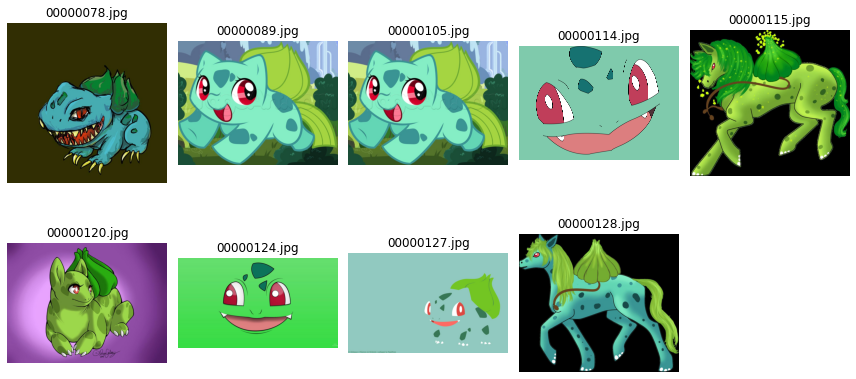

charmander: 14 error images
--------------------------------------------------------------------------------


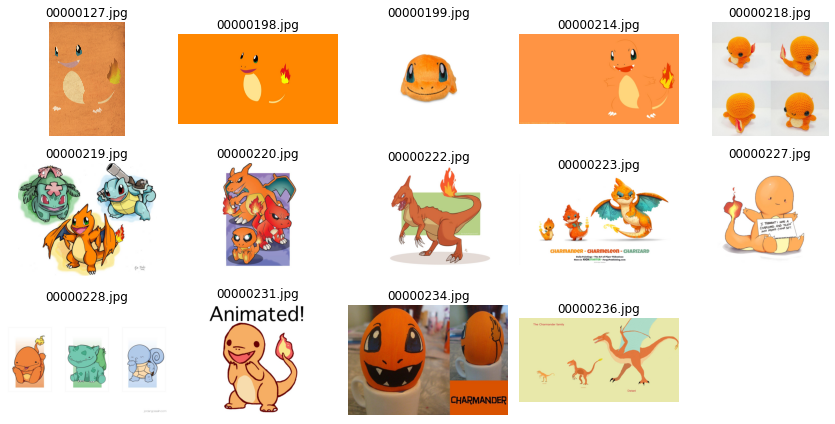

mewtwo: 5 error images
--------------------------------------------------------------------------------


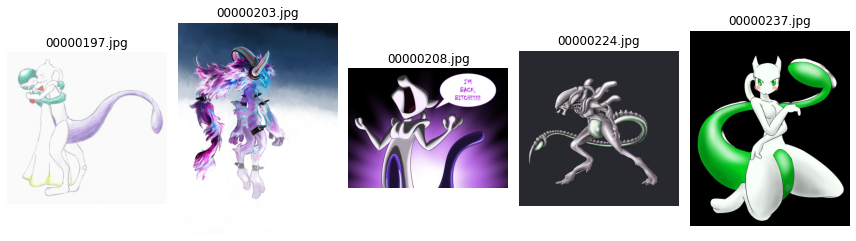

pikachu: 6 error images
--------------------------------------------------------------------------------


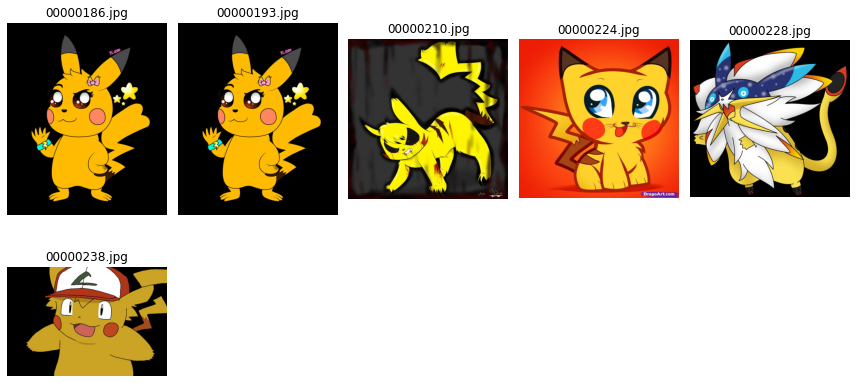

squirtle: 14 error images
--------------------------------------------------------------------------------


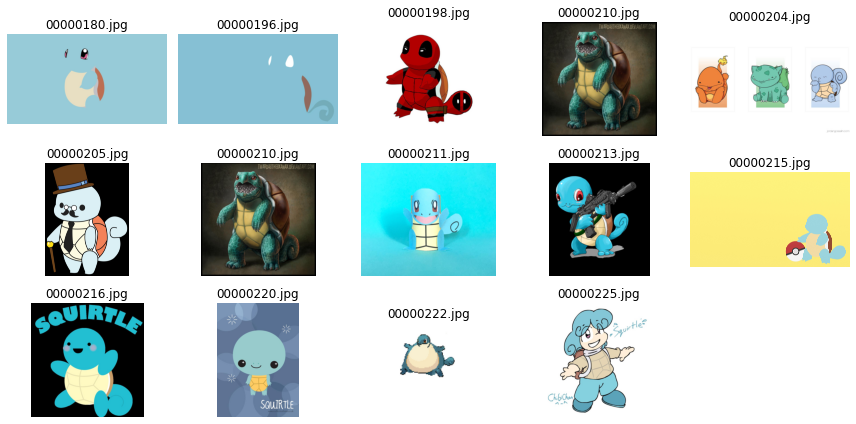

Total number of error images to be removed: 48


In [9]:
# All erroneous photos in sub-folders
err_dict = {
    'bulbasaur': ['00000078.jpg','00000089.jpg', '00000105.jpg', '00000114.jpg', '00000115.jpg', 
                  '00000120.jpg', '00000124.jpg', '00000127.jpg', '00000128.jpg'],
    
    'charmander': ['00000127.jpg', '00000198.jpg', '00000199.jpg', '00000214.jpg', '00000218.jpg', '00000219.jpg', 
                   '00000220.jpg', '00000222.jpg', '00000223.jpg', '00000227.jpg', '00000228.jpg', '00000231.jpg', 
                   '00000234.jpg', '00000236.jpg'],
    
    'mewtwo': ['00000197.jpg', '00000203.jpg', '00000208.jpg', '00000224.jpg', '00000237.jpg'],
    
    'pikachu': ['00000186.jpg', '00000193.jpg', '00000210.jpg', '00000224.jpg', '00000228.jpg', '00000238.jpg'],
    
    'squirtle': ['00000180.jpg', '00000196.jpg', '00000198.jpg', '00000210.jpg', '00000204.jpg', '00000205.jpg', 
                 '00000210.jpg', '00000211.jpg', '00000213.jpg', '00000215.jpg', '00000216.jpg', '00000220.jpg', 
                 '00000222.jpg', '00000225.jpg'],
           }

# Plot erroneous images in all sub-folders
total = 0

for subdir in image_ori.keys():
    
    # Print number of error images for each pokemon class
    err_list = err_dict[subdir]
    total += len(err_list)
    print("{}: {} error images".format(subdir, len(err_list)))
    print("-" * 80)
    
    # Plot all error images by pokemon class
    plt.figure(figsize=(12,6))
    row, col = cal_rowcol(len(err_list))
    subplot_no = 1
    
    for filename in err_dict[subdir]:
        plt.subplot(row, col, subplot_no)
        show_image('cleansed', subdir, filename)
        plt.title(filename)
        plt.axis('off')
        subplot_no += 1 
    
    plt.tight_layout()
    plt.show()

print("Total number of error images to be removed: {}".format(total))

In [10]:
# Create copy of 'image_ori' dictionary
image_c = image_ori.copy()

# Remove erroneous images based on err_dict from sub-folders
total_images, image_c = remove_image('cleansed', err_dict)

No. of images in 'bulbasaur' sub-folder under 'cleansed' folder : 41
No. of images in 'charmander' sub-folder under 'cleansed' folder : 36
No. of images in 'mewtwo' sub-folder under 'cleansed' folder : 45
No. of images in 'pikachu' sub-folder under 'cleansed' folder : 44
No. of images in 'squirtle' sub-folder under 'cleansed' folder : 37

Total no. of images in 'cleansed' folder : 203


#### Add Paddings to make Image Square

#### Duplicate Images
- Generate image hash id for each image using perceptual hash (phash) in [Image Hashing Library](https://pypi.org/project/ImageHash/).
- Duplicate images will have same hash id via phash.

In [12]:
# Generate image hash for all image files in main directory
image_id_dict = image_hash('cleansed', 'phash')

# Print out list of keys (i.e. image file) and corresponding image hash ID
for keys, values in image_id_dict.items():
    print("'{}' : {}".format(keys, values))

No. of keys in image_id_dict : 203
Key 'bulbasaur_00000069.jpg' : d0153f6bccc89395
Key 'bulbasaur_00000070.jpg' : 84527e1e3afc3f20
Key 'bulbasaur_00000072.jpg' : bec9d9a4803f1b68
Key 'bulbasaur_00000075.jpg' : c011bf17e86b83ea
Key 'bulbasaur_00000076.jpg' : e51b186583b6cd65
Key 'bulbasaur_00000077.jpg' : d1d10eac3e0e713b
Key 'bulbasaur_00000079.jpg' : fc4c3c0c1f4cde49
Key 'bulbasaur_00000080.jpg' : f1f15b2b0b1d2d0c
Key 'bulbasaur_00000081.jpg' : fac1eaa9c3599c18
Key 'bulbasaur_00000082.jpg' : d0733f6cc05a58b5
Key 'bulbasaur_00000083.jpg' : d0332bfcf8062367
Key 'bulbasaur_00000084.jpg' : fd0886e59ed3b150
Key 'bulbasaur_00000085.jpg' : c04b43072efc37b5
Key 'bulbasaur_00000087.jpg' : b4b3c34ccc3c70b3
Key 'bulbasaur_00000090.jpg' : 913a3f966ac52ec1
Key 'bulbasaur_00000091.jpg' : d0823d5b693c73e2
Key 'bulbasaur_00000092.jpg' : ed939609d22ccd66
Key 'bulbasaur_00000093.jpg' : 957860876e876ce5
Key 'bulbasaur_00000094.jpg' : eec6b0088d3d91be
Key 'bulbasaur_00000097.jpg' : e2959d783168bc63
Key '

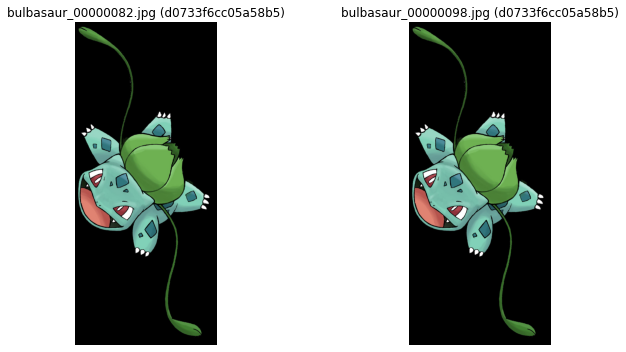

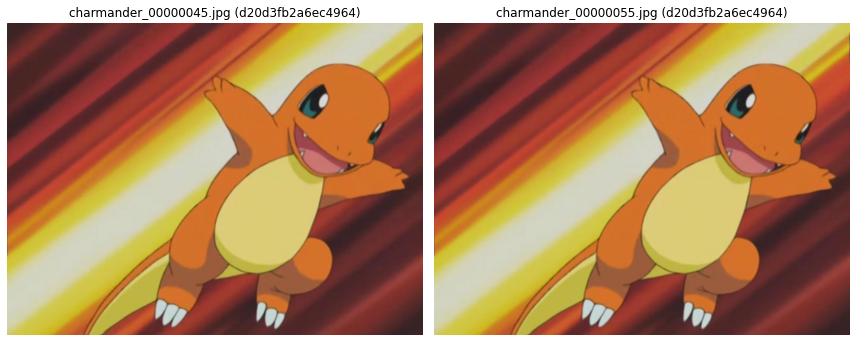

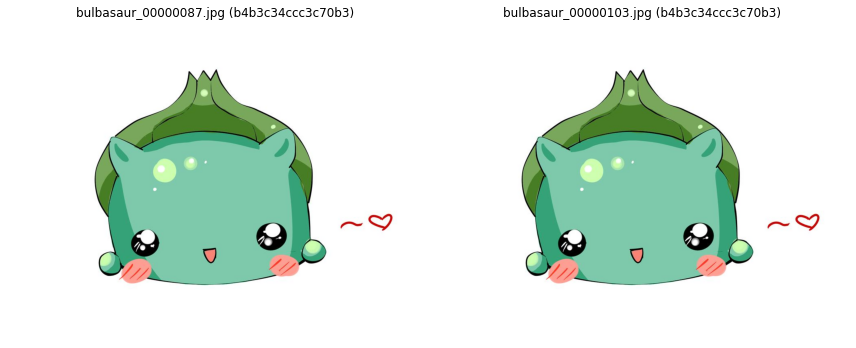

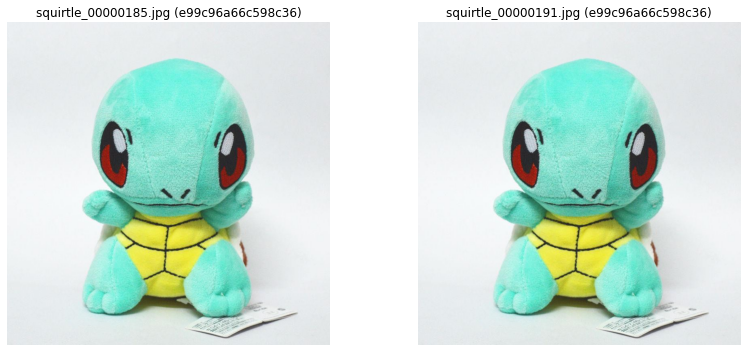

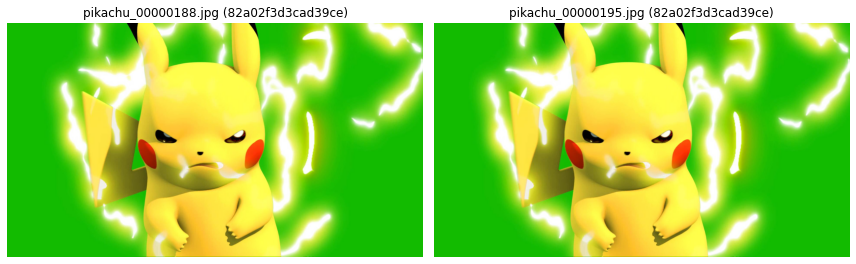

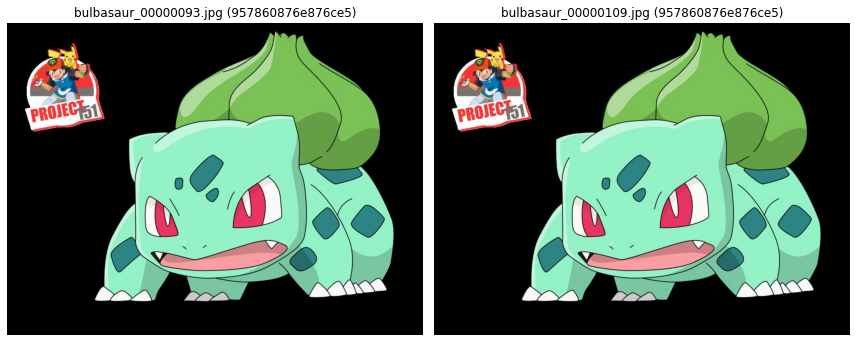

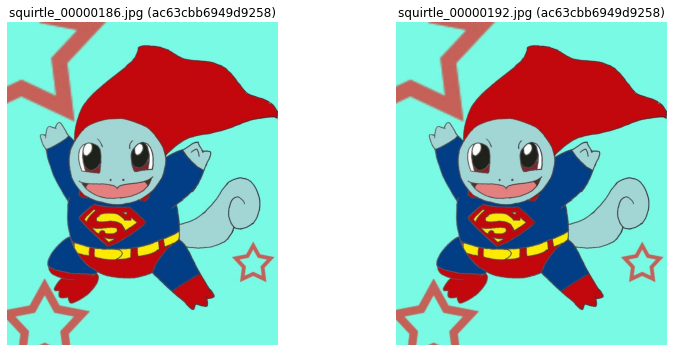

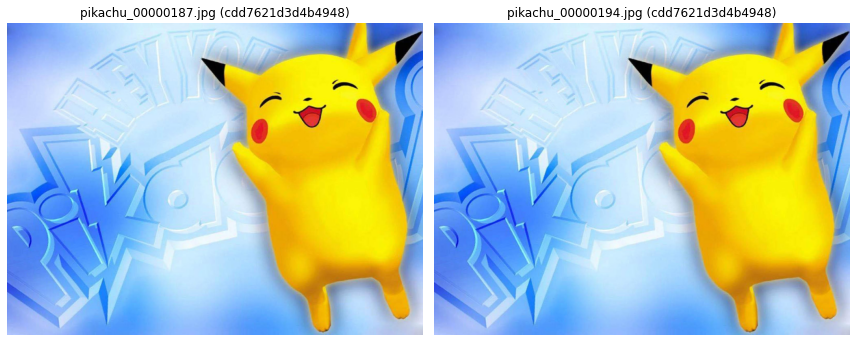

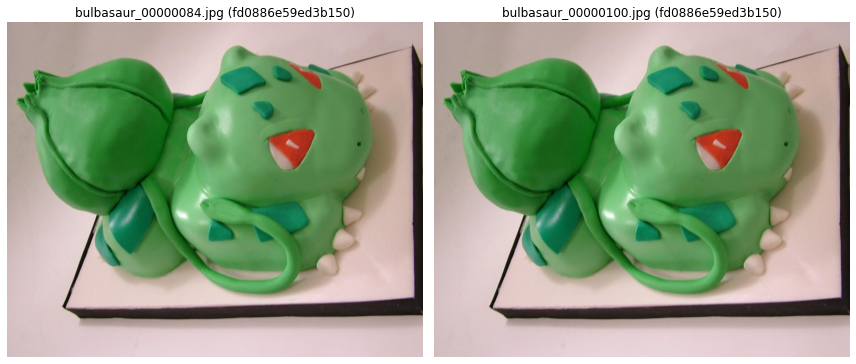

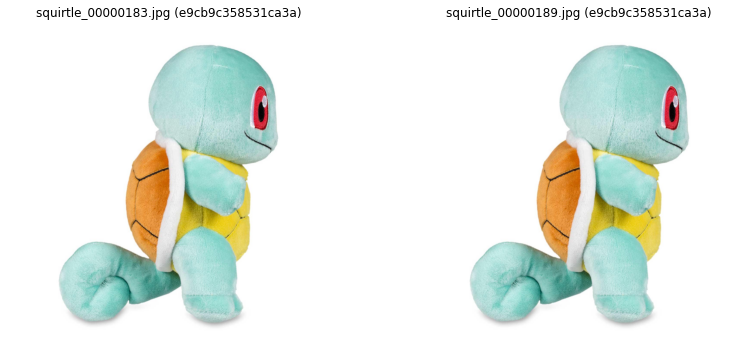

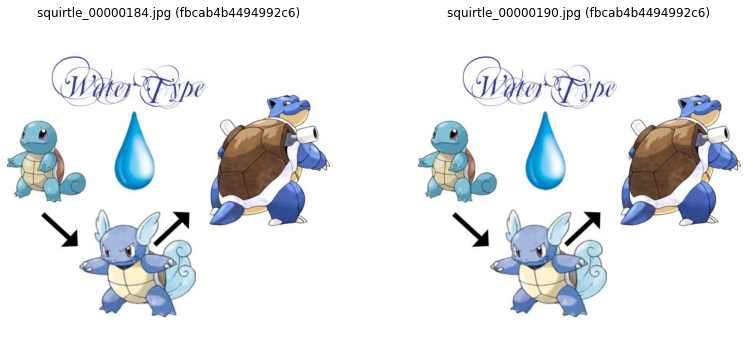

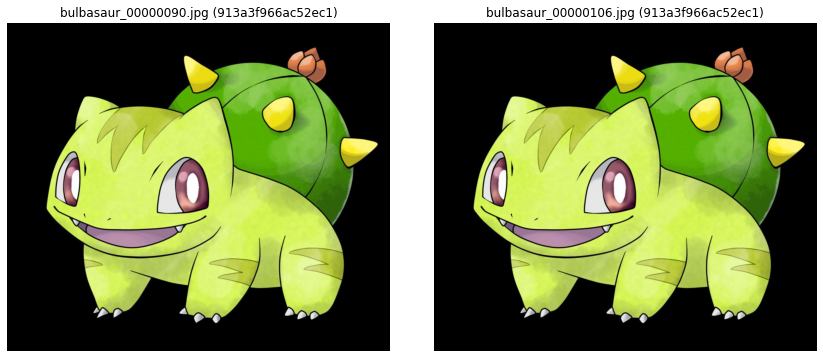

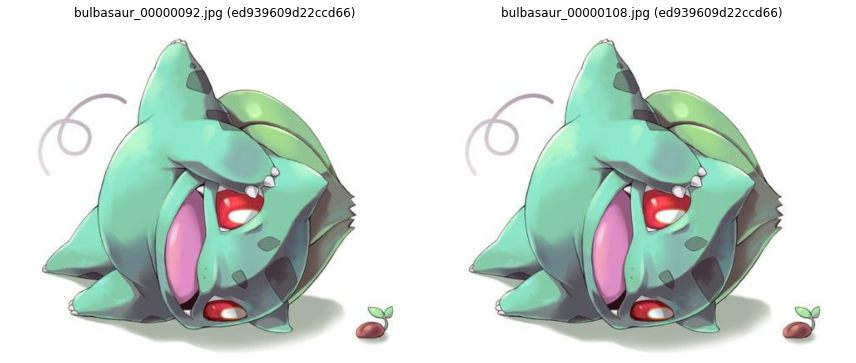

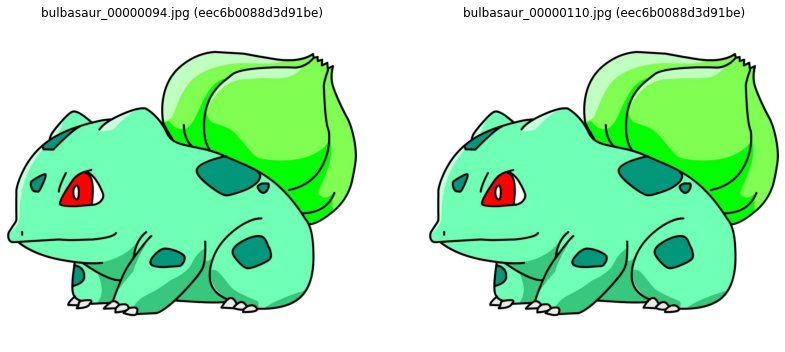

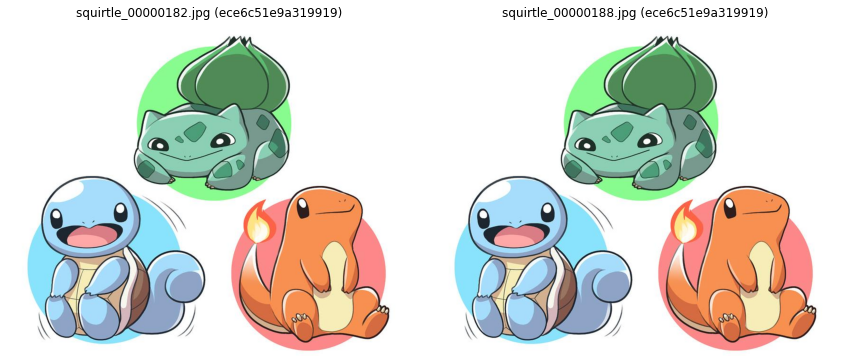

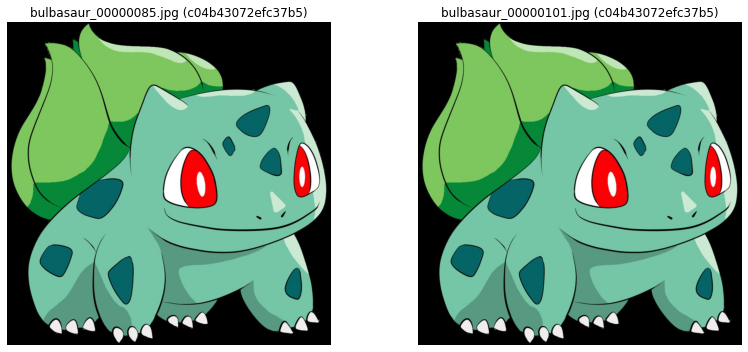

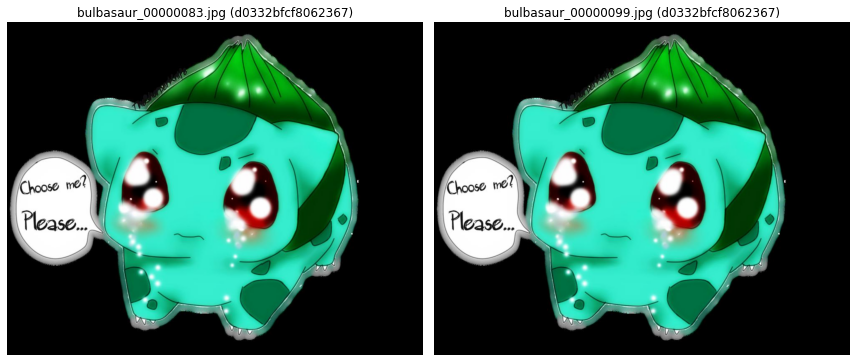

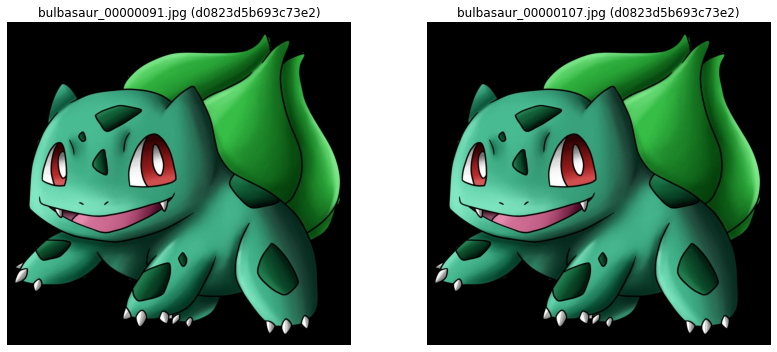

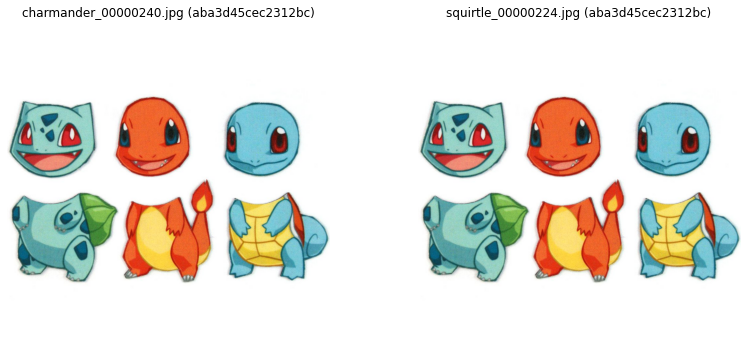

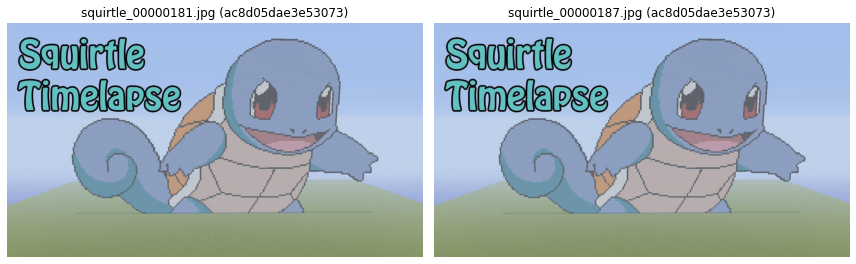

Images having same image hash id
    1. d0733f6cc05a58b5     :    bulbasaur_00000082.jpg,  bulbasaur_00000098.jpg
    2. d20d3fb2a6ec4964     :  charmander_00000045.jpg,  charmander_00000055.jpg
    3. b4b3c34ccc3c70b3     :    bulbasaur_00000087.jpg,  bulbasaur_00000103.jpg
    4. e99c96a66c598c36     :      squirtle_00000185.jpg,  squirtle_00000191.jpg
    5. 82a02f3d3cad39ce     :        pikachu_00000188.jpg,  pikachu_00000195.jpg
    6. 957860876e876ce5     :    bulbasaur_00000093.jpg,  bulbasaur_00000109.jpg
    7. ac63cbb6949d9258     :      squirtle_00000186.jpg,  squirtle_00000192.jpg
    8. cdd7621d3d4b4948     :        pikachu_00000187.jpg,  pikachu_00000194.jpg
    9. fd0886e59ed3b150     :    bulbasaur_00000084.jpg,  bulbasaur_00000100.jpg
   10. e9cb9c358531ca3a     :      squirtle_00000183.jpg,  squirtle_00000189.jpg
   11. fbcab4b4494992c6     :      squirtle_00000184.jpg,  squirtle_00000190.jpg
   12. 913a3f966ac52ec1     :    bulbasaur_00000090.jpg,  bulbasaur_00000106

In [81]:
dup_id, dup_dict = find_similar(image_id_dict, 'cleansed')

print("Images having same image hash id")
print("=" * 80)

for i, (hashid, imglist) in enumerate(dup_id.items()):
    print("%5d. %-20s : %50s" %(i+1, hashid, (',  ').join(imglist)))

print("\nList of duplicates to be removed from each sub-folder")
print("*" * 80)

for subdir, filelist in dup_dict.items():
    print(subdir)
    print("=" * 20)
    
    for i in range(len(filelist)):
        print("{}. {}".format(i, filelist[i]))
        
    print()   
    

#### Analysis based on Visual Plot
- From the plot above, we noted that there are 20 sets of duplicates images.
- Proceed to remove 20 duplicate images.

In [83]:
# Remove duplicate images
total_images, image_c = remove_image('cleansed', dup_dict)

No. of images in 'bulbasaur' sub-folder under 'cleansed' folder : 31
No. of images in 'charmander' sub-folder under 'cleansed' folder : 35
No. of images in 'mewtwo' sub-folder under 'cleansed' folder : 45
No. of images in 'pikachu' sub-folder under 'cleansed' folder : 42
No. of images in 'squirtle' sub-folder under 'cleansed' folder : 30

Total no. of images in 'cleansed' folder : 183


#### Crop Photos
- Crop photos in square format if possilbe
- Generate new photos if different pokemons of interest in same photo 
    - E.g. if bulbasaur, pikachu and squirtle appears in the same photo, we will crop out each of these pokemons to create a new photo.
    - Same pokemon appears multiple time in same photo. 
- We use Pillow to crop the images by pre-determining the parameters to crop the images; and saving it in 'crop_dict' dictionary. 
    - This ensures that we can re-create the exact same cropped samples from the original 'pokemon' dataset.
    - Reference from [Image Processing in Python with Pillow](https://auth0.com/blog/image-processing-in-python-with-pillow/)
- We will first crop out photos with only a single pokemon's image then proceed to crop out photos with multiple images in a single photo.

In [84]:
# Create 'crop_single' to store all the parameters to crop 1 image from each photo
crop_single = {
    
    'bulbasaur': {
        '00000069.jpg': (0, 256, 1024, 1280),
        '00000072.jpg': (0, 150, 630, 753), 
        '00000075.jpg': (70, 40, 1220, 1190),
        '00000076.jpg': (120, 220, 420, 520),
        '00000077.jpg': (430, 150, 980, 700),
        '00000079.jpg': (320, 0, 1020, 700),
        '00000080.jpg': (540, 65, 1420, 865),
        '00000083.jpg': (150, 50, 850, 750),
        '00000087.jpg': (160, 40, 860, 740),
        '00000092.jpg': (25, 0, 430, 395), 
        '00000093.jpg': (230, 12, 980, 762),
        '00000113.jpg': (225, 500, 490, 800), 
        '00000126.jpg': (110, 59, 710, 659),
        '00000129.jpg': (75, 15, 425, 345),
        '00000230.jpg': (150, 450, 1350, 1650),
    },
    
    'charmander': {
        '00000045.jpg': (200, 0, 1174, 881),
        '00000119.jpg': (1000, 1330, 2000, 2579),
        '00000132.jpg': (600, 130, 1300, 830),
        '00000200.jpg': (170, 20, 930, 780),
        '00000202.jpg': (35, 65, 615, 645),
        '00000211.jpg': (150, 200, 850, 900),
        '00000213.jpg': (200, 0, 480, 425),
        '00000215.jpg': (450, 0, 1150, 700),
        '00000217.jpg': (112, 112, 912, 912),
        '00000225.jpg': (100, 90, 510, 870), 
        '00000226.jpg': (520, 0, 1600, 1080),
        '00000229.jpg': (290, 290, 2190, 2190),
        '00000232.jpg': (100, 416, 450, 816),
        '00000237.jpg': (207, 240, 687, 720),
        '00000238.jpg': (0, 80, 510, 780),
        '00000244.jpg': (774, 239, 1024, 619),
    },
    
    'mewtwo': {
        '00000194.jpg': (180, 130, 1080, 1030),
        '00000196.jpg': (440, 220, 1140, 700),
        '00000199.jpg': (0, 300, 1600, 2100),
        '00000202.jpg': (200, 30, 900, 730),
        '00000209.jpg': (20, 203, 770, 953),
        '00000210.jpg': (165, 0, 445, 370),
        '00000211.jpg': (800, 20, 1300, 920),
        '00000212.jpg': (1080, 100, 1680, 1000),
        '00000215.jpg': (280, 0, 880, 600),
        '00000216.jpg': (236, 30, 736, 950),
        '00000218.jpg': (150, 30, 1150, 1030),
        '00000220.jpg': (0, 0, 570, 950),
        '00000221.jpg': (660, 30, 1060, 750),
        '00000225.jpg': (129, 535, 1129, 1535),
        '00000226.jpg': (160, 0, 1000, 720),
        '00000227.jpg': (0, 100, 450, 600),
        '00000230.jpg': (420, 50, 900, 670),
        '00000234.jpg': (480, 680, 1180, 1200),
        '00000235.jpg': (100, 30, 550, 440),
        '00000236.jpg': (790, 0, 1280, 720),
        '00000238.jpg': (10, 10, 1190, 1190),
        '00000239.jpg': (650, 250, 1050, 850),
        '00000240.jpg': (0, 0, 610, 650),
        '00000241.jpg': (350, 0, 1150, 800),
    },

    'pikachu': {
        '00000187.jpg': (730, 0, 1600, 1200),
        '00000188.jpg': (300, 0, 1300, 1080),
        '00000189.jpg': (430, 0, 1024, 830),
        '00000191.jpg': (750, 0, 1440, 900),
        '00000196.jpg': (262, 134, 762, 634),
        '00000197.jpg': (650, 170, 1410, 930),
        '00000198.jpg': (630, 15, 1930, 1450),
        '00000199.jpg': (20, 350, 1420, 1950),
        '00000200.jpg': (580, 20, 1380, 820),
        '00000202.jpg': (335, 23, 1165, 853),
        '00000203.jpg': (60, 300, 620, 860),
        '00000205.jpg': (1010, 200, 1810, 1000),
        '00000207.jpg': (250, 0, 950, 700),
        '00000213.jpg': (365, 0, 1095, 730),
        '00000215.jpg': (330, 305, 980, 955),
        '00000216.jpg': (295, 0, 1063, 768),
        '00000219.jpg': (60, 50, 620, 610),
        '00000220.jpg': (150, 150, 750, 750),
        '00000223.jpg': (290, 200, 1710, 850),
        '00000229.jpg': (0, 235, 750, 1085),
        '00000230.jpg': (1140, 250, 1920, 1030),
        '00000232.jpg': (610, 150, 985, 525),
    },
    
    'squirtle':{
        '00000179.jpg': (120, 50, 320, 250),
        '00000184.jpg': (0, 180, 150, 340),
        '00000186.jpg': (85, 230, 785, 930),
        '00000200.jpg': (0, 545, 350, 955),
        '00000202.jpg': (0, 520, 400, 1080),
        '00000206.jpg': (730, 380, 1543, 1150),
        '00000219.jpg': (200, 60, 400, 250),
        '00000226.jpg': (160, 120, 530, 600),
        '00000227.jpg': (80, 460, 420, 800),
        '00000228.jpg': (0, 0, 300, 854),
        '00000230.jpg': (220, 100, 1170, 880),
    },
}


In [85]:
# Crop photos with only 1 single pokemon image
# Save image with same file name as original photo i.e. replace original photo

for subdir in crop_single.keys():
    filelist = crop_single[subdir]
       
    for file in filelist:
        box = filelist[file]
        filepath = os.sep.join(['cleansed', subdir, file])
        im = Image.open(filepath)
        im_crop = im.crop(box)
        im_crop.save(filepath)
        

In [86]:
# Create 'crop_dict' to store all the parameters to crop multiple images in same folder
crop_multi = {
    
    'bulbasaur': {
        
        '00000118.jpg': (
            ((180, 30, 820, 670), 'bulbasaur'), 
            ((730, 15, 1400, 685), 'pikachu')
        ),
         
        '00000119.jpg': (
            ((0, 387, 120, 587), 'bulbasaur'),
            ((230, 407, 380, 587), 'bulbasaur'),
            ((380, 417, 500, 587), 'bulbasaur'),
            ((60, 300, 180, 450), 'bulbasaur'),
            ((185, 300, 305, 430), 'bulbasaur'),
            ((320, 290, 440, 440), 'bulbasaur'),
            ((105, 185, 255, 345), 'bulbasaur'),
            ((250, 180, 400, 330), 'bulbasaur'),
            ((170, 75, 320, 225), 'bulbasaur'),
        ),
                         
        '00000122.jpg': (
            ((130, 560, 600, 1060), 'bulbasaur'), 
            ((600, 520, 980, 1040), 'bulbasaur'),
            ((910, 520, 1350, 1050), 'bulbasaur'),
            ((50, 60, 490, 590), 'bulbasaur'),
            ((470, 60, 800, 600), 'bulbasaur'),
            ((780, 60, 1280, 600), 'bulbasaur'),
        ),
        
        '00000125.jpg': (
            ((0, 520, 200, 730), 'bulbasaur'),
            ((200, 470, 480, 768), 'bulbasaur'),
            ((520, 370, 1024, 768), 'bulbasaur'),
            ((0, 0, 500, 460), 'bulbasaur'),
            ((500, 0, 820, 360), 'bulbasaur'),
            ((820, 130, 1024, 350), 'bulbasaur'),
        ),
    },
    
    'charmander': {
        '00000206.jpg': (
            ((0, 0, 480, 720), 'charmander'),
            ((800, 0, 1280, 720), 'pikachu'),
        ),
        
        '00000209.jpg': (
            ((100, 0, 650, 550), 'charmander'),
            ((120, 580, 640, 950), 'charmander'),
        ),
        
        '00000233.jpg': (
            ((100, 0, 900, 1080), 'charmander'),
            ((850, 0, 1920, 1080), 'squirtle'), 
        ),
        
        '00000240.jpg': (
            ((0, 150, 340, 820), 'bulbasaur'),
            ((340, 150, 670, 820), 'charmander'),
            ((670, 150, 1000, 800), 'squirtle'),
        ),
    },
    
    'mewtwo': {
        
        '00000213.jpg': (
            ((0, 25, 200, 475), 'mewtwo'),
            ((180, 25, 450, 475), 'mewtwo'),
            ((450, 25, 700, 475), 'mewtwo'),
        ),
    },

    'pikachu': {
        
        '00000221.jpg': (
            ((100, 300, 730, 1310), 'pikachu'),
            ((700, 300, 1400, 1310), 'pikachu'),
        ),
        
        '00000227.jpg': (
            ((0, 0, 800, 1000), 'pikachu'),
            ((800, 0, 1600, 1000), 'pikachu'),
        ),
    },
    
    'squirtle':{
        
        '00000182.jpg': (
            ((20, 320, 420, 701), 'squirtle'),
            ((475, 340, 810, 680), 'charmander'),
            ((265, 25, 600, 360), 'bulbasaur'), 
        ),
        
        '00000193.jpg': (
            ((0, 490, 750, 1080), 'squirtle'),
            ((1475, 740, 1705, 970), 'squirtle'),
            ((1600, 390, 1850, 640), 'squirtle'),
        ),

        '00000201.jpg': (
            ((130, 120, 610, 735), 'squirtle'),
            ((660, 290, 1190, 860), 'bulbasaur'),
            ((1220, 150, 1920, 850), 'charmander'), 
        ),
        
        '00000203.jpg': (
            ((190, 430, 715, 955), 'bulbasaur'),
            ((600, 350, 950, 910), 'charmander'),
            ((920, 515, 1530, 920), 'squirtle'), 
        ),
        
        '00000208.jpg': (
            ((40, 430, 490, 880), 'squirtle'),
            ((450, 500, 880, 875), 'bulbasaur'), 
        ),
        
        '00000212.jpg': (
            ((60, 230, 930, 915), 'charmander'),
            ((640, 550, 1260, 950), 'bulbasaur'),
            ((980, 260, 1900, 930), 'squirtle'), 
        ),
        
        '00000214.jpg': (
            ((310, 280, 1250, 1200), 'pikachu'),
            ((1320, 280, 2240, 1200), 'bulbasaur'),
            ((1350, 1300, 2250, 2200), 'squirtle'),
            ((310, 1300, 1210, 2200), 'charmander'),
        ), 
        
        '00000217.jpg': (
            ((10, 170, 300, 600), 'squirtle'),
            ((240, 200, 520, 590), 'bulbasaur'),
            ((500, 170, 800, 590), 'charmander'),
        ),
        
        '00000229.jpg': (
            ((0, 220, 420, 700), 'squirtle'),
            ((420, 200, 800, 720), 'squirtle'),
        ),
    },
}


#### Crop photos with multiple pokemon images
- Save image as original file name + alphabetical order i.e. create new photo
    - E.g. 00000191a.jpg, 00000191b.jpg, etc. for 1st image, 2nd image, etc within same original photo 00000191.jpg
- Move cropped photo to the correct sub-folder depending on the pokemon class 
    - E.g. if 00000211.jpg, which is located in 'squirtle' sub-folder, contains 1 pikachu, 1 squirtle and 1 charmander image.
    - Move cropped pikachu image to 'pikachu' sub-folder; and cropped charmander image to 'charmander' sub-folder
- For mulitple same pokemon in photo, crop and name images as per single image photo. Original photo is retained

In [87]:
# Crop photos with mulitple pokemon images
alpha = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k' }

for subdir in crop_multi.keys():
    filelist = crop_multi[subdir]

    for file in filelist:
        boxes = filelist[file]

        for i, box in enumerate(boxes):
            box_coord = box[0] # tuple contain coordinates to crop image
            pkm = box[1] # Correct name of pokemon
            
            # Append alphabetical order to original name for new cropped images
            new_name = file.replace('.jpg', alpha[i] + '.jpg') 
            
            # Define file path where to load image and save image
            src = os.sep.join(['cleansed', subdir, file])
            dst = os.sep.join(['cleansed', pkm, new_name])
            
            # Save cropped images in correct sub-folder
            if os.path.exists(src):
                im = Image.open(src)
                im_crop = im.crop(box_coord)
                im_crop.save(dst)
            
        # Delete original image after completed cropping all images in photo
        if os.path.exists(src):
            os.remove(src)
            

In [88]:
# Update image dictionary
total_images, image_c = image_dict('cleansed')

No. of images in 'bulbasaur' sub-folder under 'cleansed' folder : 57
No. of images in 'charmander' sub-folder under 'cleansed' folder : 42
No. of images in 'mewtwo' sub-folder under 'cleansed' folder : 47
No. of images in 'pikachu' sub-folder under 'cleansed' folder : 47
No. of images in 'squirtle' sub-folder under 'cleansed' folder : 35

Total no. of images in 'cleansed' folder : 228


#### Resize Photos to 224 by 224
- Photos are first padded to make it into a square image before resizing.

In [89]:
for subdir in image_c.keys():
    filelist = image_c[subdir]
    
    for file in filelist:
        filepath = os.sep.join(['cleansed', subdir, file])
        squared_image(filepath)

#### Additional Photos Added
- Squirtle photos are lesser than the rest of pokemons. Scrap from internet to top up photos to more than 50 photos
- Photos are converted to jpg format and resize to 224 by 224

In [97]:
# Copy extra images from 'extra'
for subdir in os.listdir('extra'):
    dirpath = os.sep.join(['extra', subdir])
    
    for file in os.listdir(dirpath):
        src = os.sep.join([dirpath, file])
        dst = os.sep.join(['cleansed', subdir, file])
        im = Image.open(src)
        im.copy().save(dst)

In [98]:
# Update image dictionary after adding new images
total_images, image_c = image_dict('cleansed')

No. of images in 'bulbasaur' sub-folder under 'cleansed' folder : 60
No. of images in 'charmander' sub-folder under 'cleansed' folder : 60
No. of images in 'mewtwo' sub-folder under 'cleansed' folder : 60
No. of images in 'pikachu' sub-folder under 'cleansed' folder : 60
No. of images in 'squirtle' sub-folder under 'cleansed' folder : 60

Total no. of images in 'cleansed' folder : 300


## Prepare train, test and validation set
- Training set (70%)
- Validation and Test set (15% each)

In [103]:
# Create train, test and validation folders only when 'processed' folder has yet to be created.
if not os.path.exists('processed'):
    splitfolders.ratio('cleansed', output='processed', seed=1337, ratio=(0.7, 0.15, 0.15), group_prefix=None, move=False)


## Augment Data

In [5]:
# Initialize the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,               # Min-max scaling
    rotation_range=40,              # randomly rotate images in range of 40 degrees
    width_shift_range=0.1,          # Randomly shift images hortizontally by 10%
    height_shift_range=0.1,         # Randomly shift images vertically by 10% of image height
    brightness_range=(0.2, 0.8),    # Randomly shift brightness in range of 40% to 80%
    shear_range=20,                 # Randomly shear image in range of 20 degrees
    zoom_range=0.1,                 # Randomly zoom image by 10%
    horizontal_flip=True,           # Randomly flip images horizontally
    vertical_flip=True,             # Randomly flip images vertically
    channel_shift_range=0.25,       # Randomly shift change range by 25%
) 

# No augmentation of validation and test data. Only min-max scaling.
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# load and iterate training dataset

train_path = os.sep.join(['processed', 'train'])
valid_path = os.sep.join(['processed', 'val'])
test_path = os.sep.join(['processed', 'test'])

# All images are saved in 'RGB' mode
# List of classes to be inferred from subdirectory names
# 5 categorical classes in total

train_iter = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    shuffle=True,
    batch_size=16,
    interpolation='lanczos',
)

# load and iterate validation dataset
valid_iter = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    shuffle=True,
    batch_size=8,
    interpolation='lanczos',
)

# load and iterate test dataset
test_iter = valid_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    shuffle=False,                       # No shuffling to map filenames to batches that are yielded by data generator
    batch_size=8,
)



Found 210 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
Found 45 images belonging to 5 classes.


## Download Pre-trained Model
- [ImageNet pre-trained models](https://keras.io/api/applications/vgg/#vgg16-function) such as VGG16 have learned to classify various types of images. As such, it forms a good base for transfer learning.
- Pokemons are essentially animations - Less features to be identified compared to real animals. Hence, VGG15 should suffice - No need to use more advanced modelsuch as Channel Boosted CNN (2018), Residual Attention Module (2018), etc.

In [7]:
base_model = keras.applications.VGG16(
    weights='imagenet',           # Load weights that are pre-trained in ImageNet
    input_shape=(224, 224, 3),    # Standard size for VGG16
    include_top=False,            # Exclude the dense layer i.e. only include the convolution layer
)

print(base_model.summary())

2022-07-04 10:43:09.354232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17967 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:87:00.0, compute capability: 8.0


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Freeze Base Model

In [8]:
base_model.trainable = False

# Verify if all base layers are non-trainable
for i, layer in enumerate(base_model.layers):
    print("%s (Layer %d) : %s" %(layer.name, i, 'trainable' if layer.trainable == True else 'non-trainable'))
    

input_1 (Layer 0) : non-trainable
block1_conv1 (Layer 1) : non-trainable
block1_conv2 (Layer 2) : non-trainable
block1_pool (Layer 3) : non-trainable
block2_conv1 (Layer 4) : non-trainable
block2_conv2 (Layer 5) : non-trainable
block2_pool (Layer 6) : non-trainable
block3_conv1 (Layer 7) : non-trainable
block3_conv2 (Layer 8) : non-trainable
block3_conv3 (Layer 9) : non-trainable
block3_pool (Layer 10) : non-trainable
block4_conv1 (Layer 11) : non-trainable
block4_conv2 (Layer 12) : non-trainable
block4_conv3 (Layer 13) : non-trainable
block4_pool (Layer 14) : non-trainable
block5_conv1 (Layer 15) : non-trainable
block5_conv2 (Layer 16) : non-trainable
block5_conv3 (Layer 17) : non-trainable
block5_pool (Layer 18) : non-trainable


## Add Classification Layers
- Add dense/classification layers on top of VGG16 base layers

In [9]:
# Define classifier model

def classifier_model(opt: str ='SGD'):
    network = models.Sequential(base_model.layers, name='Pokemon_Classifier'+'_'+opt)

    network.add(layers.Flatten(name='flatten_layer'))
    network.add(layers.Dense(32, activation='relu', name='dense_1'))
    network.add(layers.Dense(16, activation='relu', name='dense_2'))
    network.add(layers.Dense(5, activation='softmax', name='output_layer'))
    
    return network

model = classifier_model()
print(model.summary())

Model: "Pokemon_Classifier_SGD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 

## Test Various Optimizers
- Available [optimizers in Keras](https://keras.io/api/optimizers/): SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
- Omit Ftrl since it is most suitable for shallow models with large and sparse feature spaces.
- Use 100 epochs and default settings to get a "feel" of their performance
- Test accuracy and loss will be used as a gauge of performance
- Plot training accuracy for all the optimizers in a single graph; similar for validation accuracy

In [19]:
# Create optimizer list
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']
history_cache = {}
perf = []

# Set random seed
np.random.seed(42)

for opt in optimizers:
    
    # Define, compile and fit model using different optimizers
    model = classifier_model(opt)           
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=train_iter, validation_data=valid_iter, steps_per_epoch=14, 
                    validation_steps=6, epochs=100, verbose=1)
    
    # Capture history for each optimizer in sequence i.e. SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax and Nadam
    history_cache[opt] = history
    
    # test loss and accuracy
    test_loss, test_acc = model.evaluate(test_iter, steps=6, batch_size=8)
    print("\nTest accuracy for optimizer '{}' : {:.4f}".format(opt, test_acc))
    
    perf_info = [
        mean(history.history['accuracy']),
        mean(history.history['val_accuracy']),
        test_acc
    ]
    
    perf.append(pd.Series(perf_info, index=['accuracy', 'val_accuracy', 'test_accuracy'], name=opt))
    
    

Epoch 1/100
14/14 [==============================] - 3s 167ms/step - loss: 1.8551 - accuracy: 0.1952 - val_loss: 1.7284 - val_accuracy: 0.2000
Epoch 2/100
14/14 [==============================] - 2s 156ms/step - loss: 1.6358 - accuracy: 0.2048 - val_loss: 1.6133 - val_accuracy: 0.2222
Epoch 3/100
14/14 [==============================] - 2s 156ms/step - loss: 1.6170 - accuracy: 0.1952 - val_loss: 1.6074 - val_accuracy: 0.2000
Epoch 4/100
14/14 [==============================] - 2s 155ms/step - loss: 1.6072 - accuracy: 0.2381 - val_loss: 1.5996 - val_accuracy: 0.2000
Epoch 5/100
14/14 [==============================] - 2s 160ms/step - loss: 1.6115 - accuracy: 0.2143 - val_loss: 1.6066 - val_accuracy: 0.2222
Epoch 6/100
14/14 [==============================] - 2s 162ms/step - loss: 1.6077 - accuracy: 0.2048 - val_loss: 1.6053 - val_accuracy: 0.2444
Epoch 7/100
14/14 [==============================] - 2s 158ms/step - loss: 1.6081 - accuracy: 0.2048 - val_loss: 1.6064 - val_accuracy: 0.2000

In [20]:
df_perf = pd.concat(perf, axis=1)
df_perf

SGD   RMSprop      Adam  Adadelta   Adagrad    Adamax  \
accuracy       0.251095  0.841762  0.914190  0.260810  0.813952  0.891571   
val_accuracy   0.263333  0.759778  0.792000  0.231333  0.774000  0.817333   
test_accuracy  0.200000  0.888889  0.955556  0.400000  0.911111  0.888889   

                  Nadam  
accuracy       0.869095  
val_accuracy   0.726889  
test_accuracy  0.866667

In [22]:
df_perf.idxmax(axis=1)

accuracy           Adam
val_accuracy     Adamax
test_accuracy      Adam
dtype: object

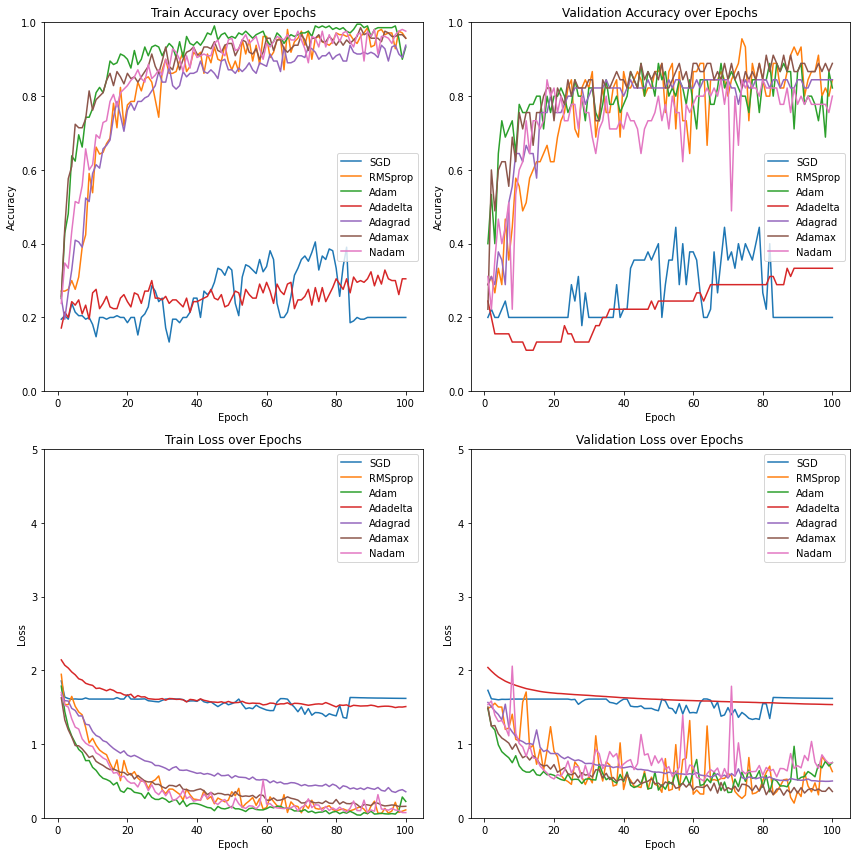

In [23]:
# Plot accuracy and loss for different optimizers
plt.figure(figsize=(12, 12))

for i, metric in enumerate(['accuracy', 'val_accuracy', 'loss', 'val_loss']):
    plt.subplot(2, 2, i+1)
    plot_compare(history_cache, metric)

plt.tight_layout()
plt.show()

#### Observations
- Adam optimizer has the highest train and validation accuracy while Adamax has the highest test accuracy.
- Adam consistently outperform the rest of optimizers throughout all epochs(i.e. Adam accuracy curve largely above the rest)
- Similarly, Adam loss is lowest among all optimizers (i.e. Adam loss curve is signficantly below the rest)
- SGD (Stochastic Gradient Descent without momentum) and Adadelta underperform. If momentum is added to SGD and learning rate is started from 1 for Adadelta, performance may be better.

## Test Various Learning Rate for Adam
- Learning rate is defaulted to 0.0001 for [Adam](https://keras.io/api/optimizers/adam/)
- Test different learning rates between 0.00001 and 0.001: 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01
- Use 100 epochs else low learning rate may not be able to converge to minimal.

In [24]:
# Create learning list
learning_rate = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
history_lr = {}
perf_lr = []

# Set random seed
np.random.seed(1111)

for lr in learning_rate:
    
    # Define, compile and fit model using Adam with different learning rate, lr
    model = classifier_model(str(lr)) 
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=train_iter, validation_data=valid_iter, steps_per_epoch=14, 
                    validation_steps=6, epochs=100, verbose=1)
    
    # Capture history for each learning rate in sequence i.e. 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005 and 0.01
    history_lr[lr] = history
    
    # test loss and accuracy
    test_loss, test_acc = model.evaluate(test_iter, steps=6, batch_size=8)
    print("\nTest accuracy for learning rate ({}) : {:.4f}".format(lr, test_acc))
    
    perf_info = [
        mean(history.history['accuracy']),
        mean(history.history['val_accuracy']),
        test_acc
    ]
    
    perf_lr.append(pd.Series(perf_info, index=['accuracy', 'val_accuracy', 'test_accuracy'], name="lr ({})".format(lr)))
    

Epoch 1/100
14/14 [==============================] - 3s 163ms/step - loss: 1.7200 - accuracy: 0.2143 - val_loss: 1.7025 - val_accuracy: 0.2000
Epoch 2/100
14/14 [==============================] - 2s 163ms/step - loss: 1.6340 - accuracy: 0.2619 - val_loss: 1.6431 - val_accuracy: 0.2222
Epoch 3/100
14/14 [==============================] - 2s 151ms/step - loss: 1.5829 - accuracy: 0.2524 - val_loss: 1.6137 - val_accuracy: 0.2667
Epoch 4/100
14/14 [==============================] - 2s 150ms/step - loss: 1.5681 - accuracy: 0.2524 - val_loss: 1.5837 - val_accuracy: 0.2667
Epoch 5/100
14/14 [==============================] - 2s 152ms/step - loss: 1.5702 - accuracy: 0.2762 - val_loss: 1.5611 - val_accuracy: 0.2667
Epoch 6/100
14/14 [==============================] - 2s 164ms/step - loss: 1.5267 - accuracy: 0.3429 - val_loss: 1.5358 - val_accuracy: 0.2667
Epoch 7/100
14/14 [==============================] - 2s 151ms/step - loss: 1.5384 - accuracy: 0.3524 - val_loss: 1.5138 - val_accuracy: 0.2889

In [25]:
# Generate data frame to show mean accuracy for each learning rate
df_perf_lr = pd.concat(perf_lr, axis=1)
df_perf_lr


lr (1e-05)  lr (5e-05)  lr (0.0001)  lr (0.0005)  lr (0.001)  \
accuracy         0.722714    0.853476     0.911619      0.81619    0.917381   
val_accuracy     0.630889    0.824000     0.782444      0.69400    0.818889   
test_accuracy    0.844444    0.888889     0.955556      0.80000    0.955556   

               lr (0.005)  lr (0.01)  
accuracy         0.216476   0.858190  
val_accuracy     0.217778   0.776889  
test_accuracy    0.200000   0.866667

In [27]:
# Select learning rate with highest accuracy
df_perf_lr.idxmax(axis=1)

accuracy          lr (0.001)
val_accuracy      lr (5e-05)
test_accuracy    lr (0.0001)
dtype: object

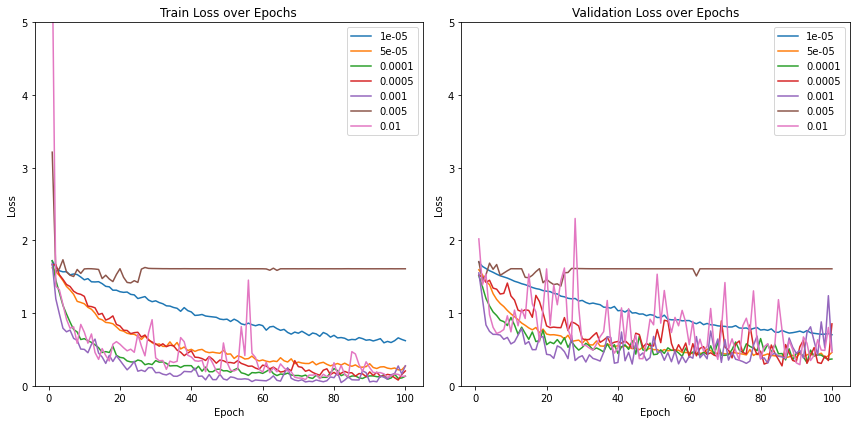

In [28]:
# Plot loss for different optimizers
plt.figure(figsize=(12, 6))

for i, metric in enumerate(['loss', 'val_loss']):
    plt.subplot(1, 2, i+1)
    plot_compare(history_lr, metric)

plt.tight_layout()
plt.show()

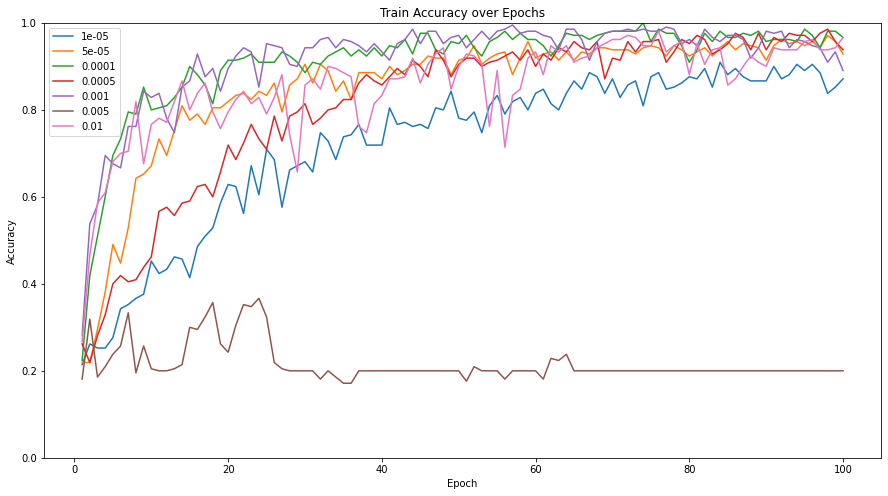

In [29]:
# plot train accuracy for different learning rates
plt.figure(figsize=(15,8))
plot_compare(history_lr, 'accuracy')

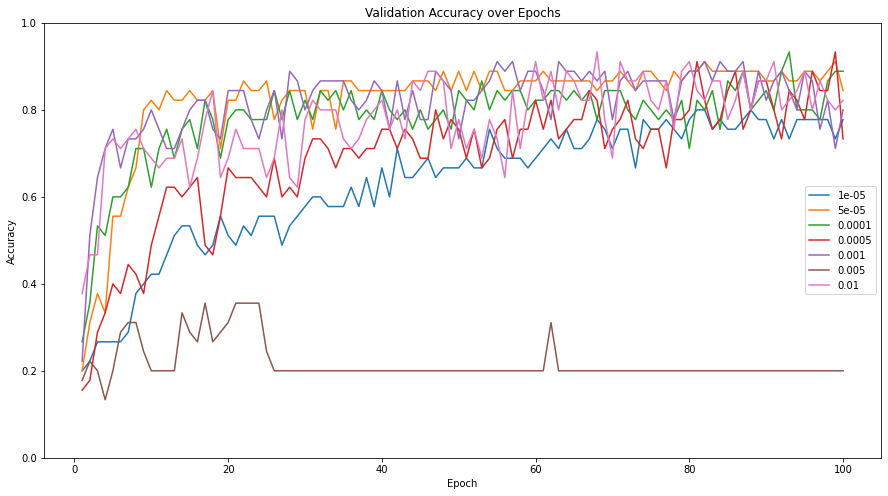

In [30]:
# plot validation accuracy for different learning rates
plt.figure(figsize=(15,8))
plot_compare(history_lr, 'val_accuracy')

#### Observations
- Learning rate 0.0001 has the highest test accuracy but 0.00005 has the highest mean validation accuracy.
- Both train and validation losses for learning rate 0.0001 are lower that that of 0.00005 but standard deviation is lower for learning rate 0.00005 compared to learning rate 0.00001
- Worst performer is learning rate 0.005 in terms of both accuracy and loss.
- Learning rate 0.0001 would be preferred over 0.00005 as learning rate 0.0001 would take a shorter time compared to 0.00005 (almost half)

## Test Various Learning Rate Schedule
- In "[Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)" article published in Towards Data Science, Suki Lau shows step decay learning rate schedule provides the best accuracy using SGD with momentum on CIFAR-10 datasets: 
<img src="data/LR schedule.jpeg" width="700" height="500">
- Learning rate is initially set at 0.01 for this experiment. We compare the performance with fixed default learning rate used in adam optimizer (i.e. 0.001)
- Note that all the learning rate schedule will be implemented via Callbacks for ease of implementation. Hence, we will not be using the standard [ExponetialDecay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) in Keras but use the version in Suki Lau's article.

#### Define Callback Functions

In [25]:
# Define Callback
def time_decay(epoch):
    """Reduce learning rate by 1/(1 + decay rate * epoch)"""
    
    initial_lr, decay_rate = 0.01, 0.01                          # Initial learning rate set at model.compile
    return initial_lr / (1.0 + decay_rate * epoch)



def step_decay(epoch):
    """Drop learning rate by a factor every few epochs"""
    
    initial_lr, drop, epochs_drop = 0.01, 0.65, 10
    return initial_lr * math.pow(drop, math.floor((epoch)/epochs_drop))



def exp_decay(epoch):
    """Reduce learning rate by exponential factor"""
    
    initial_lr, k = 0.01, 0.05
    return initial_lr * math.exp(-k*epoch)


class PrintLearningRate(keras.callbacks.Callback):
    """Print learning rate during model output"""
  
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lrate = tf.keras.backend.eval(optimizer.lr)
        print("lr: ", lrate)

        
        
# Create learning schedule dictionary
lr_schedule = {'constant': ['Constant Learning Rate'],
               'time_decay': [time_decay, 'Time-Based Decay'], 
               'step_decay': [step_decay, 'Step Decay'], 
               'exp_decay': [exp_decay, 'Exponential Decay'],
               'plateau': ['ReduceLROnPlateau']}


In [34]:
# Set random seed
np.random.seed(1222)

history_lrs = {}
perf_lrs = []

for lrs in lr_schedule.keys():
    
    # Define, compile and fit model using Adam with default learning rate (i.e. 0.0001)
    model = classifier_model(lrs) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Print learning rate during output
    printlr = PrintLearningRate()
    
    if lrs == 'constant':
        callbacks = [printlr]
    elif lrs == 'plateau':
        callbacks = [printlr, tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr=0.0001)]
    else:
        callbacks = [printlr, tf.keras.callbacks.LearningRateScheduler(lr_schedule[lrs][0])]
        
    history = model.fit(x=train_iter, validation_data=valid_iter, steps_per_epoch=14, 
                    validation_steps=6, epochs=100, verbose=1, callbacks=callbacks)
    
    # Capture history over epochs
    history_lrs[lrs] = history
        
    # test loss and accuracy
    test_loss, test_acc = model.evaluate(test_iter, steps=6, batch_size=8)
    print("\nTest accuracy for {} : {:.4f}".format(lr_schedule[lrs][-1], test_acc))
    
    perf_info = [
        mean(history.history['accuracy']),
        mean(history.history['val_accuracy']),
        test_acc
    ]
    
    perf_lrs.append(pd.Series(perf_info, index=['accuracy', 'val_accuracy', 'test_accuracy'], name=lrs))



Epoch 1/100
14/14 [==============================] - 3s 162ms/step - loss: 1.7556 - accuracy: 0.3048 - val_loss: 1.4218 - val_accuracy: 0.3111
lr:  0.001
Epoch 2/100
14/14 [==============================] - 2s 151ms/step - loss: 1.3666 - accuracy: 0.3857 - val_loss: 1.3308 - val_accuracy: 0.4667
lr:  0.001
Epoch 3/100
14/14 [==============================] - 2s 149ms/step - loss: 1.2014 - accuracy: 0.4810 - val_loss: 1.3063 - val_accuracy: 0.4444
lr:  0.001
Epoch 4/100
14/14 [==============================] - 2s 160ms/step - loss: 1.0569 - accuracy: 0.5667 - val_loss: 1.0622 - val_accuracy: 0.5111
lr:  0.001
Epoch 5/100
14/14 [==============================] - 2s 148ms/step - loss: 0.9074 - accuracy: 0.6714 - val_loss: 0.9513 - val_accuracy: 0.6667
lr:  0.001
Epoch 6/100
14/14 [==============================] - 2s 151ms/step - loss: 0.8126 - accuracy: 0.7286 - val_loss: 0.8344 - val_accuracy: 0.7556
lr:  0.001
Epoch 7/100
14/14 [==============================] - 2s 153ms/step - loss: 0

In [38]:
df_perf_lrs = pd.concat(perf_lrs, axis=1)
df_perf_lrs

constant  time_decay  step_decay  exp_decay   plateau
accuracy       0.914714    0.865429    0.902429   0.466857  0.911905
val_accuracy   0.792667    0.776889    0.840000   0.373556  0.842667
test_accuracy  0.955556    0.933333    0.888889   0.488889  0.866667

In [40]:
df_perf_lrs.idxmax(axis=1)

accuracy         constant
val_accuracy      plateau
test_accuracy    constant
dtype: object

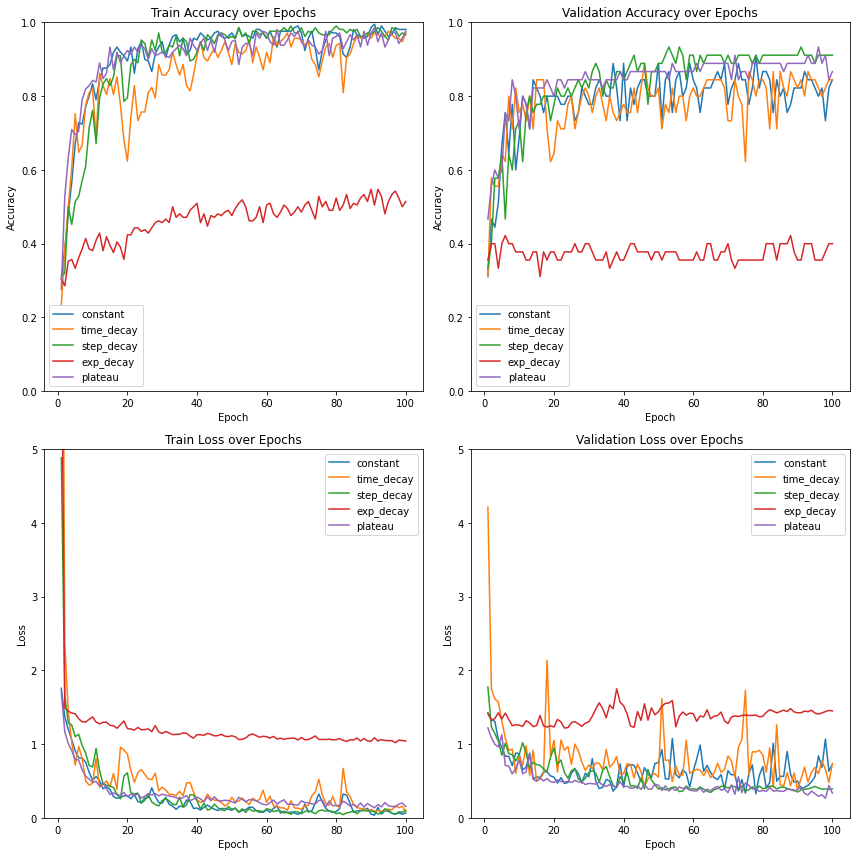

In [43]:
# Plot accuracy and loss for different optimizers
plt.figure(figsize=(12, 12))

for i, metric in enumerate(['accuracy', 'val_accuracy', 'loss', 'val_loss']):
    plt.subplot(2, 2, i+1)
    plot_compare(history_lrs, metric)

plt.tight_layout()
plt.show()

## Test with HeNormal Weights Initialization

#### Observations
- We notice that performance of different learning rate schedules deviate significantly upon every run e.g. exponential decay had the best accuracy in the previous run but preform badly in this current run
- We shall repeat this current test by initializing the weights with HeNormal to see if performance is stablized.


In [44]:
# Define classifier model with HeNormal

def classifier_He_model(opt: str ='SGD'):
    """Classifier model with HeNormal weights intialization at the dense layers"""
    network = models.Sequential(base_model.layers, name='Pokemon_Classifier'+'_'+opt)

    network.add(layers.Flatten(name='flatten_layer'))
    network.add(layers.Dense(32, activation='relu', kernel_initializer='HeNormal', name='dense_1'))     # Apply HeNormal on dense_1
    network.add(layers.Dense(16, activation='relu', kernel_initializer='HeNormal', name='dense_2'))     # Apply HeNormal on dense_2
    network.add(layers.Dense(5, activation='softmax', name='output_layer'))
    
    return network

model = classifier_He_model()
print(model.summary())

Model: "Pokemon_Classifier_SGD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 

In [45]:
# Set random seed
np.random.seed(1333)

history_He_lrs = {}
perf_He_lrs = []

for lrs in lr_schedule.keys():
    
    # Define, compile and fit model using Adam with default learning rate (i.e. 0.001)
    model = classifier_He_model(lrs) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Print learning rate during output
    printlr = PrintLearningRate()
    
    if lrs == 'constant':
        callbacks = [printlr]
    elif lrs == 'plateau':
        callbacks = [printlr, tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr=0.0001)]
    else:
        callbacks = [printlr, tf.keras.callbacks.LearningRateScheduler(lr_schedule[lrs][0])]
        
    history = model.fit(x=train_iter, validation_data=valid_iter, steps_per_epoch=14, 
                    validation_steps=6, epochs=100, verbose=1, callbacks=callbacks)
    
    # Capture history over epochs
    history_He_lrs[lrs] = history
        
    # test loss and accuracy
    test_loss, test_acc = model.evaluate(test_iter, steps=6, batch_size=8)
    print("\nTest accuracy for {} : {:.4f}".format(lr_schedule[lrs][-1], test_acc))
    
    perf_info = [
        mean(history.history['accuracy']),
        mean(history.history['val_accuracy']),
        test_acc
    ]
    
    perf_He_lrs.append(pd.Series(perf_info, index=['accuracy', 'val_accuracy', 'test_accuracy'], name=lrs))



Epoch 1/100
14/14 [==============================] - 3s 161ms/step - loss: 2.3688 - accuracy: 0.1952 - val_loss: 1.6118 - val_accuracy: 0.2667
lr:  0.001
Epoch 2/100
14/14 [==============================] - 2s 152ms/step - loss: 1.4651 - accuracy: 0.3190 - val_loss: 1.4104 - val_accuracy: 0.4222
lr:  0.001
Epoch 3/100
14/14 [==============================] - 2s 165ms/step - loss: 1.2840 - accuracy: 0.4095 - val_loss: 1.1058 - val_accuracy: 0.4889
lr:  0.001
Epoch 4/100
14/14 [==============================] - 2s 151ms/step - loss: 1.0966 - accuracy: 0.5381 - val_loss: 1.1058 - val_accuracy: 0.4444
lr:  0.001
Epoch 5/100
14/14 [==============================] - 2s 152ms/step - loss: 1.0865 - accuracy: 0.5857 - val_loss: 1.0780 - val_accuracy: 0.4889
lr:  0.001
Epoch 6/100
14/14 [==============================] - 2s 166ms/step - loss: 0.9894 - accuracy: 0.6143 - val_loss: 1.2482 - val_accuracy: 0.4444
lr:  0.001
Epoch 7/100
14/14 [==============================] - 2s 148ms/step - loss: 0

In [46]:
df_perf_He_lrs = pd.concat(perf_He_lrs, axis=1)
df_perf_He_lrs

constant  time_decay  step_decay  exp_decay   plateau
accuracy       0.877524    0.844095    0.198714   0.526048  0.895381
val_accuracy   0.786889    0.787333    0.200000   0.401556  0.833333
test_accuracy  0.888889    0.933333    0.200000   0.511111  0.911111

In [47]:
df_perf_He_lrs.idxmax(axis=1)

accuracy            plateau
val_accuracy        plateau
test_accuracy    time_decay
dtype: object

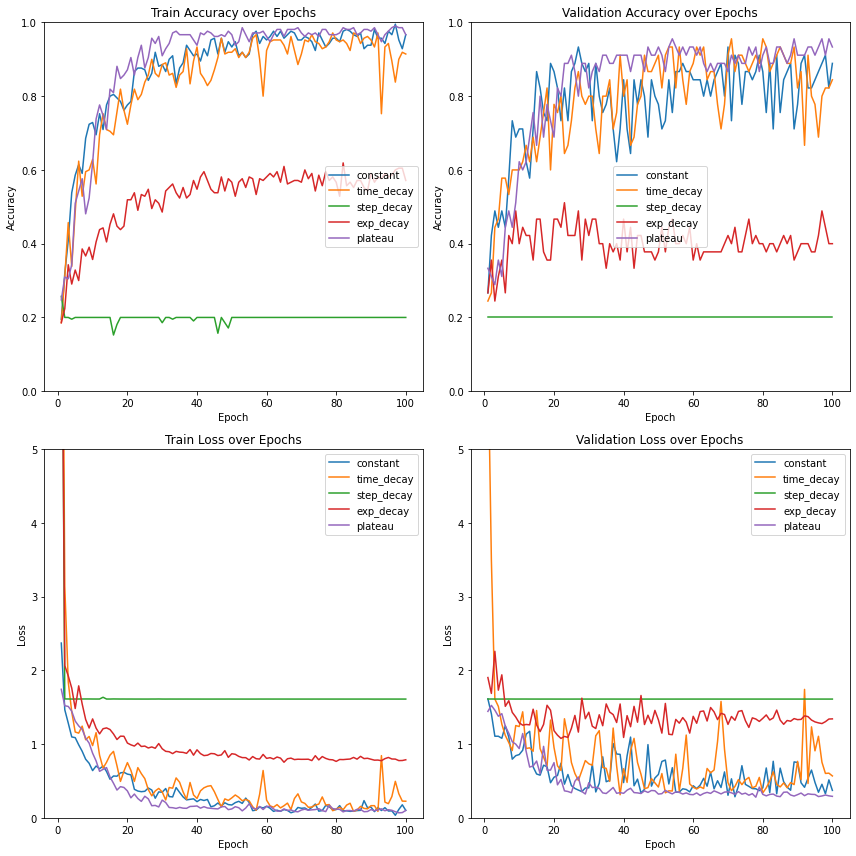

In [48]:
# Plot accuracy and loss for different optimizers
plt.figure(figsize=(12, 12))

for i, metric in enumerate(['accuracy', 'val_accuracy', 'loss', 'val_loss']):
    plt.subplot(2, 2, i+1)
    plot_compare(history_He_lrs, metric)

plt.tight_layout()
plt.show()

#### Observations
- No marked improvement in performance with HeNormal initialization.
- Performance of learning rate schedules especially time decay and step decay are varies drastically between each run despite the use of HeNormal.

## Final Model
- Select Adam optimizer with default initial learning rate of 0.001 as higher learning rate seems to result in poor performance. Moreover, it is shown that the default adam learning rate performs without any scheduling (i.e. 95.56% of test accuracy).
- Hence, Plateau reduce learning rate schedule is chosen since learning rate will only be reduced if validation accuracy persists for 5 consecutive run.
- We choose 100 epochs run since no obvious over-fitting is detected so far during our training runs. In addition, having more epochs may help to provide a slight boost in accuracy although we noted that accuracy especially validation accuracy seems to stagnate after 20 epochs.

In [49]:
# Set callbacks for model_checkpoint to save best model as 'Pokemon_Classifier.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("Pokemon_Classifier.h5", monitor='val_accuracy', save_best_only=True)

# Print cumulative training time after each epoch when verbose = 1
class PrintTotalTime(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time()

    def on_epoch_end(self, epoch, logs=None):
        total_time = round(time() - self.start_time, 2)
        print("\nCumulative training time after epoch {}: {}".format(epoch + 1, total_time))

    def on_train_end(self, logs=None):
        total_time = round(time() - self.start_time, 2)
        print("\nCumulative training time: {}\n".format(total_time))

        
class PrintLearningRate(keras.callbacks.Callback):
    """Print learning rate during model output"""
  
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lrate = tf.keras.backend.eval(optimizer.lr)
        print("lr: ", lrate)

plateau_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, min_lr=0.0001)

callbacks = [PrintLearningRate(), model_checkpoint, plateau_lr, PrintTotalTime()]
    
np.random.seed(1444)

# Define, compile and fit model using Adam, using 0.001 learning rate and plateau decay
model = classifier_model('adam') 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=train_iter, validation_data=valid_iter, steps_per_epoch=14, 
                    validation_steps=6, epochs=100, verbose=1, callbacks=callbacks)

Epoch 1/100
14/14 [==============================] - 3s 161ms/step - loss: 1.8556 - accuracy: 0.2857 - val_loss: 1.5990 - val_accuracy: 0.4667
lr:  0.001

Cumulative training time after epoch 1: 2.91
Epoch 2/100
14/14 [==============================] - 2s 149ms/step - loss: 1.5122 - accuracy: 0.3381 - val_loss: 1.3057 - val_accuracy: 0.4889
lr:  0.001

Cumulative training time after epoch 2: 5.24
Epoch 3/100
14/14 [==============================] - 2s 150ms/step - loss: 1.2032 - accuracy: 0.5286 - val_loss: 1.1431 - val_accuracy: 0.5333
lr:  0.001

Cumulative training time after epoch 3: 7.58
Epoch 4/100
14/14 [==============================] - 2s 150ms/step - loss: 0.9617 - accuracy: 0.6000 - val_loss: 1.0009 - val_accuracy: 0.5556
lr:  0.001

Cumulative training time after epoch 4: 9.92
Epoch 5/100
14/14 [==============================] - 2s 150ms/step - loss: 0.7970 - accuracy: 0.7381 - val_loss: 0.9293 - val_accuracy: 0.6000
lr:  0.001

Cumulative training time after epoch 5: 12.24

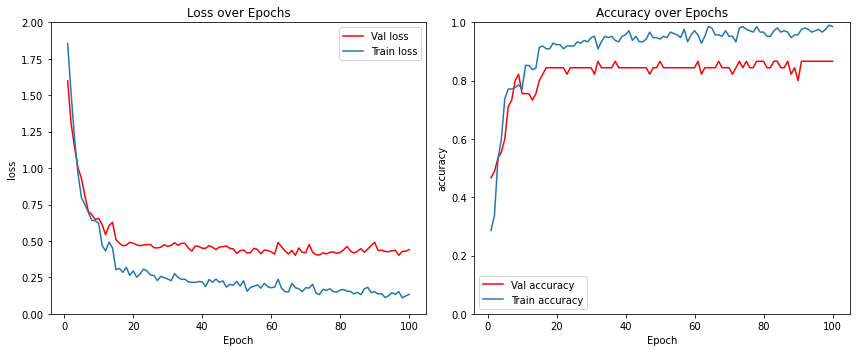

In [58]:
# Plot loss and Accuracy graphs side-by-side
plt.figure(figsize=(12,5))
for i, col in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, i+1)
    plot_perf(history, col)

plt.tight_layout()

In [51]:
result = pd.DataFrame(history.history, columns=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
result.describe()

loss    accuracy    val_loss  val_accuracy
count  100.000000  100.000000  100.000000    100.000000
mean     0.285042    0.916762    0.502068      0.823556
std      0.271510    0.113901    0.181673      0.075265
min      0.109521    0.285714    0.401034      0.466667
25%      0.159545    0.927381    0.428770      0.844444
50%      0.205558    0.952381    0.450439      0.844444
75%      0.263416    0.966667    0.475250      0.844444
max      1.855577    0.990476    1.598981      0.866667

In [52]:
print("Correlation between validation accuracy and train accuracy : {}"
      .format(result.corr().loc['val_accuracy', 'accuracy'].round(3)))

print("Mean of validation accuracy versus train accuracy: {} versus {}"
      .format(result['val_accuracy'].mean().round(3), result['accuracy'].mean().round(3)))

Correlation between validation accuracy and train accuracy : 0.949
Mean of validation accuracy versus train accuracy: 0.824 versus 0.917


#### Observations
- Accuracy for validation and training shows slight divergence starting from 20 epochs onwards. However, we noted the divergence is not significant enough to confirm overfitting (correlation is about 0.949)
- Hence, regularization (L1 or L2), batch normalization, drop-out may not be that effective.
- Proceed to perform fine-tuning to see if there are further improvement.

## Fine-tune Model

In [53]:
# Unfreeze the base model
base_model.trainable = True

# Fine tune model with very low learning rate.
model.compile(optimizer=keras.optimizers.Adam(learning_rate = .000001),  # Very low learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train model with a quarter of total epoch
history1 = model.fit(x=train_iter, validation_data=valid_iter, steps_per_epoch=14, validation_steps=6, epochs=25, verbose=1 )

# test loss and accuracy
test_loss, test_acc = model.evaluate(test_iter, steps=6, batch_size=8)

Epoch 1/25
14/14 [==============================] - 4s 181ms/step - loss: 0.1255 - accuracy: 0.9619 - val_loss: 0.4254 - val_accuracy: 0.8667
Epoch 2/25
14/14 [==============================] - 2s 150ms/step - loss: 0.0880 - accuracy: 0.9952 - val_loss: 0.4412 - val_accuracy: 0.8444
Epoch 3/25
14/14 [==============================] - 2s 155ms/step - loss: 0.1095 - accuracy: 0.9714 - val_loss: 0.4021 - val_accuracy: 0.8667
Epoch 4/25
14/14 [==============================] - 2s 153ms/step - loss: 0.0919 - accuracy: 0.9857 - val_loss: 0.3883 - val_accuracy: 0.8667
Epoch 5/25
14/14 [==============================] - 2s 154ms/step - loss: 0.0571 - accuracy: 1.0000 - val_loss: 0.3781 - val_accuracy: 0.8667
Epoch 6/25
14/14 [==============================] - 2s 155ms/step - loss: 0.0844 - accuracy: 0.9714 - val_loss: 0.3763 - val_accuracy: 0.8667
Epoch 7/25
14/14 [==============================] - 2s 167ms/step - loss: 0.0544 - accuracy: 0.9952 - val_loss: 0.3758 - val_accuracy: 0.8667
Epoch 

In [55]:
print("Test Accuracy after fine tuning : {}".format(test_acc))
print("Test Loss after fine tuning     : {}".format(test_loss))

Test Accuracy after fine tuning : 0.9777777791023254
Test Loss after fine tuning     : 0.08545375615358353


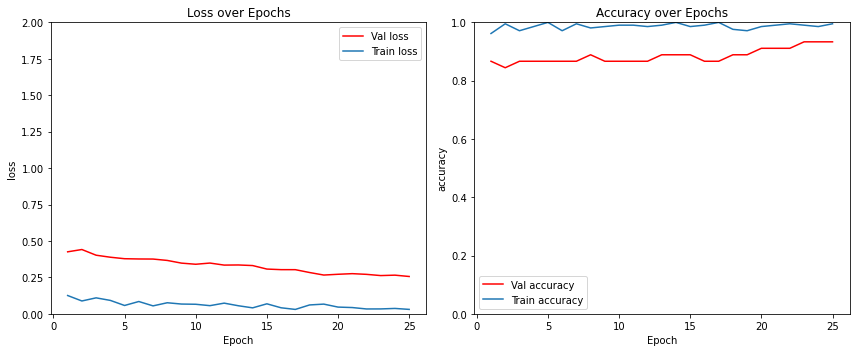

In [59]:
# Plot loss and Accuracy graphs
plt.figure(figsize=(12,5))
for i, col in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, i+1)
    plot_perf(history1, col)

plt.tight_layout()

In [60]:
result1 = pd.DataFrame(history1.history, columns=['loss', 'accuracy', 'val_loss', 'val_accuracy'])
result1.describe()

loss   accuracy   val_loss  val_accuracy
count  25.000000  25.000000  25.000000     25.000000
mean    0.061351   0.986857   0.330139      0.884444
std     0.024777   0.009939   0.054454      0.024845
min     0.030032   0.961905   0.256096      0.844444
25%     0.041245   0.985714   0.275517      0.866667
50%     0.057131   0.990476   0.334266      0.866667
75%     0.073136   0.995238   0.375762      0.888889
max     0.125496   1.000000   0.441189      0.933333

In [61]:
print("Correlation between validation accuracy and train accuracy : {}"
      .format(result1.corr().loc['val_accuracy', 'accuracy'].round(3)))

print("Mean of validation accuracy versus train accuracy: {} versus {}"
      .format(result1['val_accuracy'].mean().round(3), result['accuracy'].mean().round(3)))

Correlation between validation accuracy and train accuracy : 0.111
Mean of validation accuracy versus train accuracy: 0.884 versus 0.917


#### Observations
- Validation accuracy is consistently below train accuracy.
- Validation accuracy improve after fine tuning while train accuracy already near 100% mark. Graphical representation suggest convergence of validation accuracy towards train accuracy for higher epoch run.
- Any further attempt to improve the model may result in over-fitting especially when training data set is small (Only 60 images per class for training)

## Prediction

In [62]:
# Test data info captured in test_iter
print("No. of test samples: {}".format(test_iter.samples))
print("No. of test classes: {}".format(len(test_iter.class_indices)))

# Class mappings (total 9 classes)
print("\nClass labels mapping")
print("="*80)

for k, v in test_iter.class_indices.items():
    print("{} is assigned to value : {}".format(k, v))

print()
    
# List of all filenames in test directory
for file in test_iter.filenames:
    print(file)

No. of test samples: 45
No. of test classes: 5

Class labels mapping
bulbasaur is assigned to value : 0
charmander is assigned to value : 1
mewtwo is assigned to value : 2
pikachu is assigned to value : 3
squirtle is assigned to value : 4

bulbasaur/00000083.jpg
bulbasaur/00000119a.jpg
bulbasaur/00000122b.jpg
bulbasaur/00000122d.jpg
bulbasaur/00000122e.jpg
bulbasaur/00000123.jpg
bulbasaur/00000125f.jpg
bulbasaur/00000126.jpg
bulbasaur/00000201b.jpg
charmander/00000204.jpg
charmander/00000215.jpg
charmander/00000237.jpg
charmander/00000239.jpg
charmander/00000240b.jpg
charmander/00000242.jpg
charmander/00000303.jpg
charmander/00000304.jpg
charmander/00000307.jpg
mewtwo/00000207.jpg
mewtwo/00000219.jpg
mewtwo/00000231.jpg
mewtwo/00000233.jpg
mewtwo/00000234.jpg
mewtwo/00000236.jpg
mewtwo/00000243.jpg
mewtwo/00000244.jpg
mewtwo/00000302.jpg
pikachu/00000199.jpg
pikachu/00000212.jpg
pikachu/00000221b.jpg
pikachu/00000225.jpg
pikachu/00000226.jpg
pikachu/00000227b.jpg
pikachu/00000235.jpg
p

In [66]:
# Generate label numpy arraybased on list of files stored in test_iter image data generator
label = np.array([test_iter.class_indices[file.split('/')[0]] for file in test_iter.filenames])

# Reset test_iter before running prediction to ensure file sequence is unchanged
test_iter.reset()
proba = model.predict(test_iter, steps=6, verbose=1)

# Determine index with the highest probability as predicted value
pred = np.argmax(proba, axis=1)

# Get inverse mapping i.e. values map to key
get_pkm = {v: k for k, v in test_iter.class_indices.items()}
print(get_pkm)

print("\nPredicted versus Actual")
print("=" * 80)

for i in range(len(label)):
    actual = get_pkm[label[i]]
    predict = get_pkm[pred[i]]
    
    print("Actual: {}     ->     Predicted: {}".format(actual, predict))

6/6 [==============================] - 0s 10ms/step
{0: 'bulbasaur', 1: 'charmander', 2: 'mewtwo', 3: 'pikachu', 4: 'squirtle'}

Predicted versus Actual
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: bulbasaur     ->     Predicted: bulbasaur
Actual: charmander     ->     Predicted: charmander
Actual: charmander     ->     Predicted: charmander
Actual: charmander     ->     Predicted: charmander
Actual: charmander     ->     Predicted: charmander
Actual: charmander     ->     Predicted: charmander
Actual: charmander     ->     Predicted: charmander
Actual: charmander     ->     Predicted: charmander
Actual: charmander     ->     Pre

## Generate Confusion Matrix
- Generate confusion matrix via tensorflow
- Convert confusion matrix into data frame so as to have meaningful row and column labels

In [72]:
# Generate confustion matrix, cm
cm = confusion_matrix(label, pred, num_classes=5)

# Convert to data frame, df_cm
df_cm = pd.DataFrame(np.array(cm), index=test_iter.class_indices.keys(), columns=test_iter.class_indices.keys())
df_cm

bulbasaur  charmander  mewtwo  pikachu  squirtle
bulbasaur           9           0       0        0         0
charmander          0           9       0        0         0
mewtwo              0           1       8        0         0
pikachu             0           0       0        9         0
squirtle            0           0       0        0         9

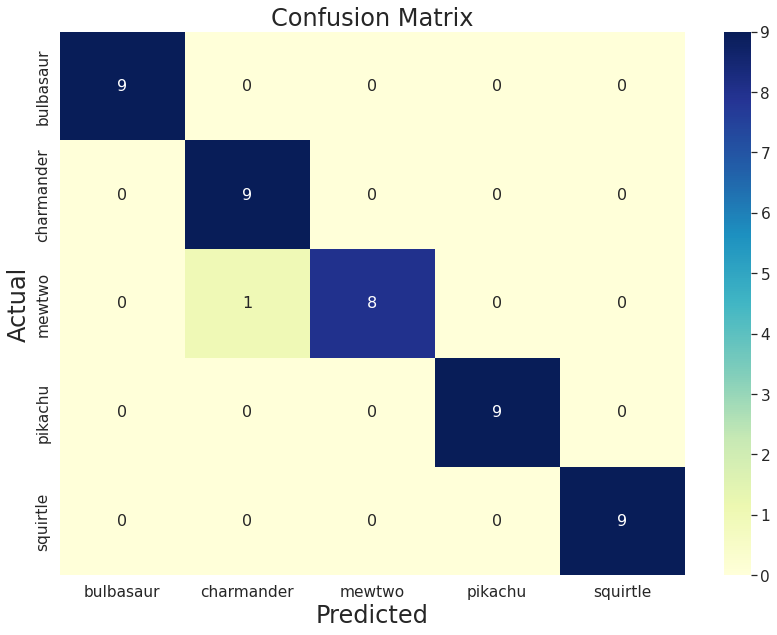

In [73]:
plt.figure(figsize=(14,10))
sns.set(font_scale=1.4) # for column and row label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu') # font size of annotation within table

plt.xlabel('Predicted', fontsize=24)
plt.ylabel('Actual', fontsize=24)
plt.title('Confusion Matrix', fontsize=24)
plt.show()

## Additional Performance Metrics
- Compute Pecision, Recall, F1 Score and AUC (Area Under Curve)

In [78]:
perf_metrics(label, pred, 'adam')

precision    0.980000
recall       0.977778
f_score      0.977709
accuracy     0.977778
auc          0.986111
Name: adam, dtype: float64

In [80]:
# Save model
model.save("Pokemon_Classifier.h5")


## Final Evaluation and Conclusion
- Significant efforts have been undertaken to ensure the quality of the images, which directly boost the accuracy of the model:
    - Duplicates are removed to avoid over-fitting.
    - Erroneous images are removed to avoid confusion for the model.
    - Each image only contains 1 pokemon to assist in training.
    - Additional images are taken from the web to ensure an even image sample for all classes. 
- Different optimizers, learning rates and learning schedules were experimented to get the best hyper-pararmeters for the model
- Fine tuning boost the performance of the model - Validation accuracy shows slight convergence towards training accuracy.
- Confusion matrix, precision, recall, accuracy, auc were near 100% region, which demonstrates the effectiveness of our model in predicting the 5 pokemon classes.
- However, our model needs further testing since only 45 images (i.e. 9 per class) were used for testing. 